<a href="https://colab.research.google.com/github/iandvecchia/tcc_ianvecchia/blob/main/EDA_imoveis_porto_alegre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1: Importação das bibliotecas:


In [64]:
!pip install spreg libpysal

In [65]:
import pandas as pd
from google.colab import drive
from tabulate import tabulate
import matplotlib.pyplot as plt
import folium
from folium.plugins import MarkerCluster
import seaborn as sns
import geopandas as gpd
from matplotlib.colors import Normalize
import matplotlib.cm as cm

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import statsmodels.formula.api as smf
import numpy as np
from spreg import ML_Lag, ML_Error
from libpysal.weights import Queen
from spreg import ML_Lag, ML_Error
from libpysal.weights import Queen





from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score



In [66]:
url_dados_bairros = 'https://raw.githubusercontent.com/iandvecchia/tcc_ianvecchia/data/base_dados/dados_bairros.xlsx'
url_dados_imoveis = 'https://raw.githubusercontent.com/iandvecchia/tcc_ianvecchia/data/base_dados/porto_alegre.xlsx'
url_bairros_shapefile = 'https://raw.githubusercontent.com/iandvecchia/tcc_ianvecchia/data/base_dados/bairros_shapefile/Bairros_LC12112_16.shp'

#2: Conexão com o Google Drive:

In [67]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
!ls "/content/drive/My Drive/EDA - imobiliario porto alegre"

 base_dados  'EDA - imoveis_porto_alegre.ipynb'   fontes


#3: Importação da base de dados:

## 3.1: Dados Anuncios de Imóveis:

In [69]:
data = pd.read_excel(url_dados_imoveis)

data.to_excel('data_portoalegre.xlsx', index=False)

## 3.2: Bairros de Porto Alegre Shapefiles:

In [70]:
bairros_shapefile = gpd.read_file(url_bairros_shapefile)

In [71]:
bairros_shapefile = bairros_shapefile.rename(columns={'NOME': 'bairro'})

In [72]:
print(tabulate(bairros_shapefile.head(5), headers='keys', tablefmt='pretty'))

+---+----------+--------+------------------+--------+---------------------+-----------+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## 3.3 Dados sobre os bairros:

In [73]:
dados_bairros = pd.read_excel(url_dados_bairros)

In [74]:
print(tabulate(data.head(), headers='keys', tablefmt='pretty'))
print(tabulate(data.info(), headers='keys', tablefmt='pretty'))


+---+----------------------------------------------------------------------------------------------------+------------+--------+---------+------------------------+-----------------------------------------------------------------------------------------------------------------------+----------+----------------+----------+-------------------+--------------+---------+------------------+--------------------+--------+------------+------------+
|   |                                              Anúncio                                               |     ID     |  Tipo  |  Preço  |         Imovel         |                                                         Link                                                          |   Área   | Preço do metro |   CEP    |      Estado       |    Cidade    |  IBGE   |      Bairro      |        Rua         | Número |  Latitude  | Longitude  |
+---+----------------------------------------------------------------------------------------------------+--------

#4: Limpeza e tratamendo dos dados:

## 4.1: padronização do nome das colunas:

In [75]:
# Padronizar os nomes das colunas conforme o mapeamento fornecido
data.rename(columns={
    'Anúncio': 'anuncio',
    'ID': 'id',
    'Tipo': 'tipo',
    'Preço': 'preco',
    'Imovel': 'imovel',
    'Link': 'link',
    'Área': 'area',
    'Preço do metro': 'preco_metro',
    'CEP': 'cep',
    'Estado': 'estado',
    'Cidade': 'cidade',
    'IBGE': 'cod_ibge',
    'Bairro': 'bairro',
    'Rua': 'rua',
    'Número': 'numero',
    'Latitude': 'latitude',
    'Longitude': 'longitude'
}, inplace=True)

## 4.2: Ajustes na coluna bairro:


*  ajuste na coluna bairro para maiusculo;
*  ajuste no nome dos bairros de acordo com o padrão do shapefile



In [76]:
data['bairro'] = data['bairro'].str.upper()

print(data['bairro'].unique())

['LAGEADO' 'CENTRO HISTÓRICO' 'SÃO GERALDO' 'PARTENON' 'HÍPICA'
 'CAVALHADA' 'SARANDI' 'VILA NOVA' 'BOA VISTA DO SUL' 'BELÉM VELHO'
 'CAMPO NOVO' 'CRISTAL' 'PETRÓPOLIS' 'JARDIM BOTÂNICO' 'CHAPÉU DO SOL'
 'FLORESTA' 'TRISTEZA' 'PRAIA DE BELAS' 'JARDIM DO SALSO'
 'SANTA MARIA GORETTI' 'CAMAQUÃ' 'ANCHIETA' 'IPANEMA' 'SANTA ROSA DE LIMA'
 'JARDIM ITU' 'SÃO SEBASTIÃO' 'JARDIM SÃO PEDRO' 'NONOAI'
 'PASSO DAS PEDRAS' 'AUXILIADORA' 'VILA IPIRANGA' 'MEDIANEIRA'
 'NAVEGANTES' 'FARRAPOS' 'RESTINGA' 'PASSO DA AREIA' 'ESPÍRITO SANTO'
 'SANTANA' 'AZENHA' 'VILA JOÃO PESSOA' 'TERESÓPOLIS' 'JARDIM CARVALHO'
 'JARDIM LINDÓIA' 'EXTREMA' 'CASCATA' 'RIO BRANCO' 'FARROUPILHA' 'GLÓRIA'
 'SÃO JOÃO' 'MOINHOS DE VENTO' 'CRISTO REDENTOR' 'BELA VISTA'
 'JARDIM SABARÁ' 'INDEPENDÊNCIA' 'HUMAITÁ' 'PONTA GROSSA'
 'JARDIM LEOPOLDINA' 'LAMI' 'VILA JARDIM' 'SANTO ANTÔNIO' 'GUARUJÁ'
 'SANTA TEREZA' 'BOM FIM' 'HIGIENÓPOLIS' 'MENINO DEUS' 'MORRO SANTANA'
 'VILA ASSUNÇÃO' 'COSTA E SILVA' 'LOMBA DO PINHEIRO' 'CHÁCARA DAS PED

In [77]:
# Dicionário de mapeamento para normalizar os nomes dos bairros
mapeamento_bairros = {
    "CORONEL APARÍCIO BORGES": "CEL. APARICIO BORGES",
    'VILA ASSUNÇÃO': 'VILA  ASSUNÇÃO',
    'MONT SERRAT': 'MONTSERRAT',
}

# Aplicando o mapeamento na coluna NM_BAIRRO
data["bairro"] = data["bairro"].replace(mapeamento_bairros)

# Verificar novamente se ainda há discrepâncias após a normalização
bairros_dados = set(data["bairro"].unique())
bairros_shapefile_unico = set(bairros_shapefile["bairro"].unique())

faltantes_shapefile = bairros_dados - bairros_shapefile_unico
print("Bairros ausentes no shapefile:", faltantes_shapefile)

faltantes_dados = bairros_shapefile_unico - bairros_dados
print("Bairros ausentes nos dados:", faltantes_dados)

Bairros ausentes no shapefile: set()
Bairros ausentes nos dados: {'PITINGA'}


## 4.3: Remover anuncios duplicados:

In [78]:
# Contagem de linhas antes da remoção de duplicatas
linhas_antes = len(data)

# Remover duplicatas
data.drop_duplicates(subset=['id'], inplace=True)

# Contagem de linhas depois da remoção de duplicatas
linhas_depois = len(data)

# Calcular e exibir o número de duplicatas removidas
duplicatas_removidas = linhas_antes - linhas_depois
print(f"Número de valores duplicados removidos: {duplicatas_removidas}")

Número de valores duplicados removidos: 0


# 5: Visão Geral dos Dados:

In [79]:
# 1. Visão Geral dos Dados

# a) Verificar as dimensões do dataset
print("Dimensões do dataset:", data.shape)

# b) Exibir as primeiras linhas do dataset para visualizar a estrutura
print("\nPrimeiras linhas do dataset:")
print(tabulate(data.head(), headers='keys', tablefmt='pretty'))

# c) Checar os tipos de dados de cada coluna
print("\nTipos de dados de cada coluna:")
print(tabulate(data.dtypes.reset_index(), headers=['Column', 'Data Type'], tablefmt='pretty'))

Dimensões do dataset: (41312, 17)

Primeiras linhas do dataset:
+---+----------------------------------------------------------------------------------------------------+------------+--------+---------+------------------------+-----------------------------------------------------------------------------------------------------------------------+----------+-------------+----------+-------------------+--------------+----------+------------------+--------------------+--------+------------+------------+
|   |                                              anuncio                                               |     id     |  tipo  |  preco  |         imovel         |                                                         link                                                          |   area   | preco_metro |   cep    |      estado       |    cidade    | cod_ibge |      bairro      |        rua         | numero |  latitude  | longitude  |
+---+-------------------------------------------------

## 5.1: Valores Faltantes por Coluna:

In [80]:
# a) Contagem de valores faltantes por coluna
missing_values_count = data.isnull().sum()
print("\nContagem de valores faltantes por coluna:")
print(tabulate(missing_values_count.reset_index(), headers=['Column', 'Missing Values'], tablefmt='pretty'))

# b) Proporção de valores faltantes por coluna
missing_values_percentage = (data.isnull().sum() / len(data)) * 100
print("\nProporção de valores faltantes por coluna:")
print(tabulate(missing_values_percentage.reset_index(), headers=['Column', 'Missing Percentage'], tablefmt='pretty'))


Contagem de valores faltantes por coluna:
+----+-------------+----------------+
|    |   Column    | Missing Values |
+----+-------------+----------------+
| 0  |   anuncio   |       20       |
| 1  |     id      |       0        |
| 2  |    tipo     |       0        |
| 3  |    preco    |       0        |
| 4  |   imovel    |       0        |
| 5  |    link     |       0        |
| 6  |    area     |       0        |
| 7  | preco_metro |       0        |
| 8  |     cep     |       0        |
| 9  |   estado    |       0        |
| 10 |   cidade    |       0        |
| 11 |  cod_ibge   |       0        |
| 12 |   bairro    |       0        |
| 13 |     rua     |     12216      |
| 14 |   numero    |     16726      |
| 15 |  latitude   |     16175      |
| 16 |  longitude  |     16175      |
+----+-------------+----------------+

Proporção de valores faltantes por coluna:
+----+-------------+---------------------+
|    |   Column    | Missing Percentage  |
+----+-------------+---------

## 5.2:  Identificando os valores das colunas Tipo e Imóvel:

In [81]:
# Função para mostrar os valores únicos e a contagem de colunas específicas
def verificar_valores_colunas_especificas(df, colunas):
    for coluna in colunas:
        if coluna in df.columns:
            print(f"\nColuna: {coluna}")
            print("Valores únicos:")
            print(df[coluna].value_counts(dropna=False))
            print("-" * 40)
        else:
            print(f"Coluna {coluna} não encontrada no DataFrame.")

colunas = ['tipo', 'imovel']
# Verificar os valores de cada coluna
verificar_valores_colunas_especificas(data, colunas)


Coluna: tipo
Valores únicos:
tipo
RENTAL    23500
SALE      17812
Name: count, dtype: int64
----------------------------------------

Coluna: imovel
Valores únicos:
imovel
OFFICE                    23578
BUSINESS                   9334
SHED_DEPOSIT_WAREHOUSE     2959
COMMERCIAL_PROPERTY        2463
BUILDING                   2462
ALLOTMENT_LAND              509
CLINIC                        7
Name: count, dtype: int64
----------------------------------------


# 6: Separando os dados em Rental (Aluguel) e Sale (venda):

In [82]:
# Separar o dataset em dois subconjuntos: Rental e Sale
dados_rental = data[data['tipo'] == 'RENTAL']
dados_sale = data[data['tipo'] == 'SALE']

## 6.1: Analise Descritiva de Rental (Aluguel) e Sale (Venda):

In [83]:
# 3. Análise Estatística Descritiva

# a) Estatísticas descritivas para Rental:
descriptive_stats_rental = dados_rental.describe()
print("\nEstatísticas descritivas para Rental:")
print(tabulate(descriptive_stats_rental, headers='keys', tablefmt='pretty'))

# b) Estatísticas descritivas para Sale:
descriptive_stats_sale = dados_sale.describe()
print("\nEstatísticas descritivas para Sale: ")
print(tabulate(descriptive_stats_sale, headers='keys', tablefmt='pretty'))


Estatísticas descritivas para Rental:
+-------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+---------------------+---------------------+
|       |         id         |       preco       |        area        |    preco_metro     |        cep        |     cod_ibge      |      latitude       |      longitude      |
+-------+--------------------+-------------------+--------------------+--------------------+-------------------+-------------------+---------------------+---------------------+
| count |      23500.0       |      23500.0      |      23500.0       |      23500.0       |      23500.0      |      23500.0      |       11037.0       |       11037.0       |
| mean  | 2589319181.9691916 | 7782.218723404255 | 311.2900425531915  | 44.44702127659574  | 90598469.13591489 | 4313712.416553192 | -30.03681470544532  | -51.19843449343118  |
|  std  | 166131165.30260706 | 15458.96219601404 | 2653.2923928631203 | 435.

## 6.2: Identificando Outliers:
O método do Intervalo Interquartílico (IQR) é uma técnica robusta para identificar outliers em dados, baseando-se na dispersão dos dados ao redor da mediana, ao invés da média.

Definição do IQR:

O IQR é a diferença entre o terceiro quartil (Q3) e o primeiro quartil (Q1) dos dados. Os quartis dividem os dados em quatro partes iguais:

    Primeiro Quartil (Q1): Mediana do primeiro meio dos dados (25% dos dados são menores que Q1).

    Terceiro Quartil (Q3): Mediana do segundo meio dos dados (75% dos dados são menores que Q3).
Cálculo do IQR:
    
    1. Ordenar os Dados: Primeiro, os dados são ordenados.
    2. Calcular Q1 e Q3:
      Q1 é o valor médio entre o menor valor dos dados e a mediana.
      Q3 é o valor médio entre a mediana e o maior valor dos dados.
    3. IQR = Q3 - Q1
Determinação dos Limites para Outliers:

    Limite Inferior: Q1 - 1.5 * IQR
    Limite Superior: Q3 + 1.5 * IQR
  
Identificação de Outliers:
    
    Qualquer dado abaixo do limite inferior ou acima do limite superior é considerado um outlier.

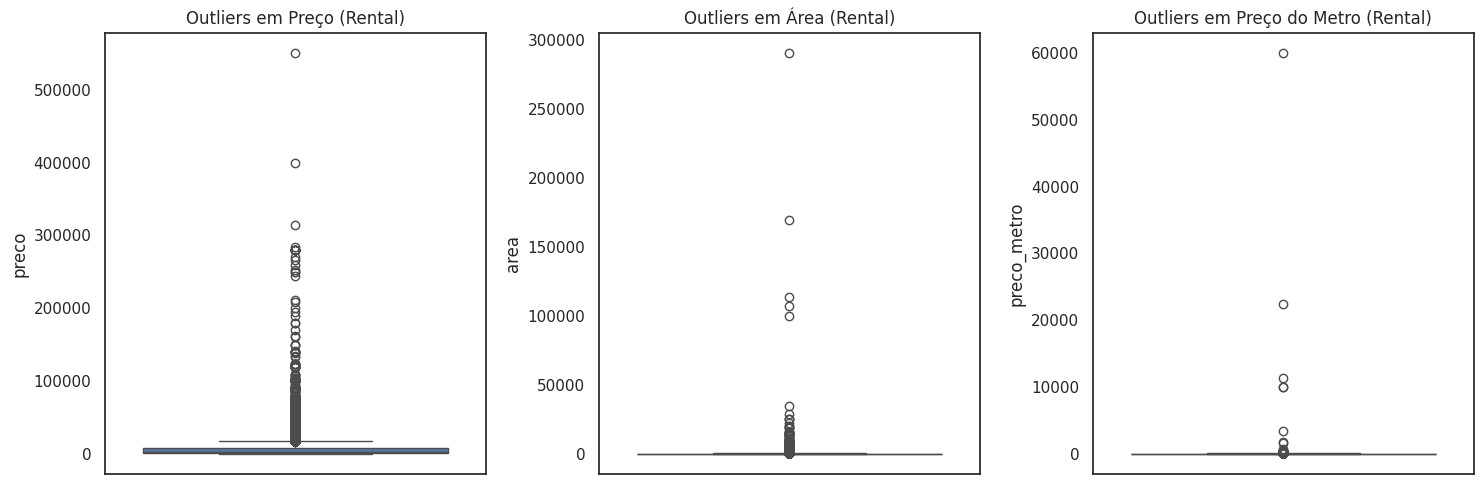

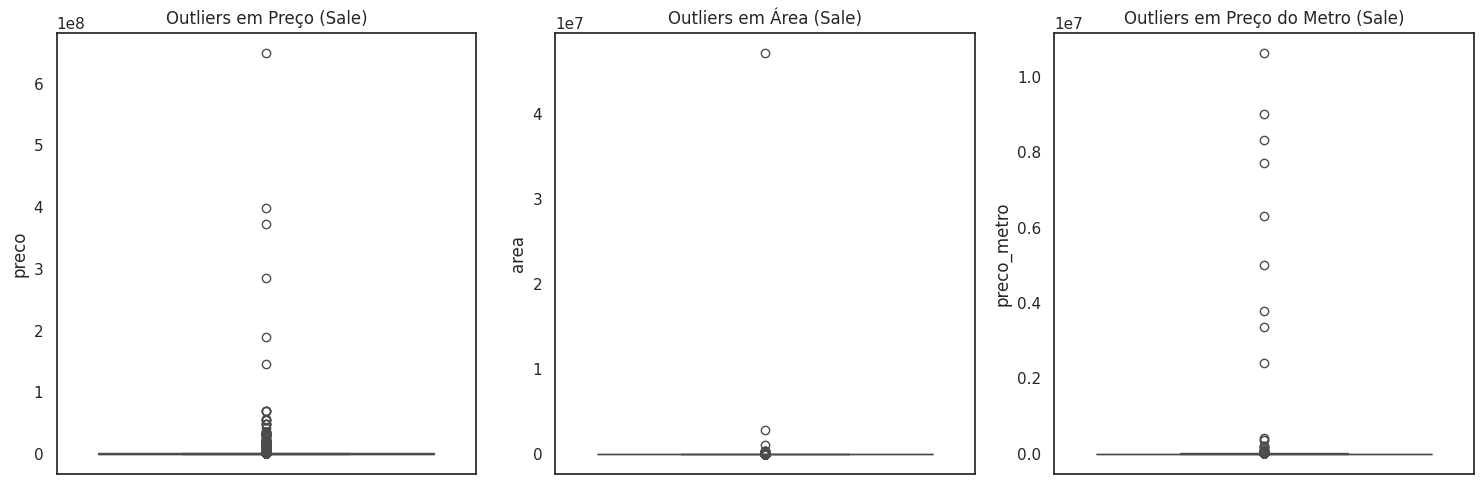

In [84]:
# Função para identificar outliers usando o método IQR (Interquartile Range)
def identificar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    outliers = df[(df[coluna] < limite_inferior) | (df[coluna] > limite_superior)]
    return outliers

# 1. Detecção de Outliers para Rental
# Boxplot para Preço, Área, e Preço do metro
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=dados_rental['preco'])
plt.title('Outliers em Preço (Rental)')

plt.subplot(1, 3, 2)
sns.boxplot(y=dados_rental['area'])
plt.title('Outliers em Área (Rental)')

plt.subplot(1, 3, 3)
sns.boxplot(y=dados_rental['preco_metro'])
plt.title('Outliers em Preço do Metro (Rental)')

plt.tight_layout()
plt.show()

# Identificar outliers em Preço, Área, e Preço do metro para Rental
outliers_preco_rental = identificar_outliers(dados_rental, 'preco')
outliers_area_rental = identificar_outliers(dados_rental, 'area')
outliers_preco_metro_rental = identificar_outliers(dados_rental, 'preco_metro')


# 2. Detecção de Outliers para Sale
# Boxplot para Preço, Área, e Preço do metro
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=dados_sale['preco'])
plt.title('Outliers em Preço (Sale)')

plt.subplot(1, 3, 2)
sns.boxplot(y=dados_sale['area'])
plt.title('Outliers em Área (Sale)')

plt.subplot(1, 3, 3)
sns.boxplot(y=dados_sale['preco_metro'])
plt.title('Outliers em Preço do Metro (Sale)')

plt.tight_layout()
plt.show()

# Identificar outliers em Preço, Área, e Preço do metro para Sale
outliers_preco_sale = identificar_outliers(dados_sale, 'preco')
outliers_area_sale = identificar_outliers(dados_sale, 'area')
outliers_preco_metro_sale = identificar_outliers(dados_sale, 'preco_metro')

In [85]:
# 1. Detecção de Outliers para Rental
# Identificar outliers em Preço, Área, e Preço do metro para Rental
outliers_preco_rental = identificar_outliers(dados_rental, 'preco')
outliers_area_rental = identificar_outliers(dados_rental, 'area')
outliers_preco_metro_rental = identificar_outliers(dados_rental, 'preco_metro')

# Combinar todos os outliers em um único DataFrame para Rental
outliers_rental = pd.concat([outliers_preco_rental, outliers_area_rental, outliers_preco_metro_rental]).drop_duplicates()

# 2. Detecção de Outliers para Sale
# Identificar outliers em Preço, Área, e Preço do metro para Sale
outliers_preco_sale = identificar_outliers(dados_sale, 'preco')
outliers_area_sale = identificar_outliers(dados_sale, 'area')
outliers_preco_metro_sale = identificar_outliers(dados_sale, 'preco_metro')

# Combinar todos os outliers em um único DataFrame para Sale
outliers_sale = pd.concat([outliers_preco_sale, outliers_area_sale, outliers_preco_metro_sale]).drop_duplicates()

# Juntar todos os outliers em um único DataFrame
outliers_total = pd.concat([outliers_rental, outliers_sale]).drop_duplicates()
print(outliers_total.shape)
# Exibir alguns exemplos de outliers combinados usando tabulate

(3791, 17)


In [86]:
# Função para eliminar outliers usando o método IQR (Interquartile Range)
def eliminar_outliers(df, coluna):
    Q1 = df[coluna].quantile(0.25)
    Q3 = df[coluna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 3 * IQR
    limite_superior = Q3 + 3 * IQR
    dados_filtrados = df[(df[coluna] >= limite_inferior) & (df[coluna] <= limite_superior)]
    return dados_filtrados

# Eliminar outliers para Rental
dados_rental_filtrado = eliminar_outliers(dados_rental, 'preco')
dados_rental_filtrado = eliminar_outliers(dados_rental_filtrado, 'area')
dados_rental_filtrado = eliminar_outliers(dados_rental_filtrado, 'preco_metro')

# Eliminar outliers para Sale
dados_sale_filtrado = eliminar_outliers(dados_sale, 'preco')
dados_sale_filtrado = eliminar_outliers(dados_sale_filtrado, 'area')
dados_sale_filtrado = eliminar_outliers(dados_sale_filtrado, 'preco_metro')

In [87]:
print(dados_sale_filtrado.shape)
print(dados_rental_filtrado.shape)

(15791, 17)
(20909, 17)


In [88]:
dados_sale_filtrado.to_excel('dados_sale_filtrado.xlsx', index=False)
dados_rental_filtrado.to_excel('dados_rental_filtrado.xlsx',  index=False)

In [89]:
# Dicionário para traduzir os valores da coluna 'imovel'
traducao_imovel = {
    "OFFICE": "SALA COMERCIAL",
    "BUSINESS": "PONTO COMERCIAL",
    "COMMERCIAL_PROPERTY": "IMÓVEL COMERCIAL",
    "SHED_DEPOSIT_WAREHOUSE": "GALPÃO/DEPÓSITO",
    "BUILDING": "PRÉDIO COMERCIAL",
    "ALLOTMENT_LAND": "LOTES/TERRENOS",
    "CLINIC": "SALA COMERCIAL"
}

# Aplicar a tradução na coluna 'imovel' para a base dados_sale_filtrado
dados_sale_filtrado['imovel'] = dados_sale_filtrado['imovel'].replace(traducao_imovel)

# Aplicar a tradução na coluna 'imovel' para a base dados_rental_filtrado
dados_rental_filtrado['imovel'] = dados_rental_filtrado['imovel'].replace(traducao_imovel)

# Exibir algumas linhas das bases atualizadas para verificar as mudanças
print("Dados Sale Filtrado (Atualizado):")
print(dados_sale_filtrado['imovel'].head())

print("\nDados Rental Filtrado (Atualizado):")
print(dados_rental_filtrado['imovel'].head())

Dados Sale Filtrado (Atualizado):
23516    PONTO COMERCIAL
23517    PONTO COMERCIAL
23631     LOTES/TERRENOS
23646     LOTES/TERRENOS
23657    PONTO COMERCIAL
Name: imovel, dtype: object

Dados Rental Filtrado (Atualizado):
1     SALA COMERCIAL
2     SALA COMERCIAL
9     LOTES/TERRENOS
17    SALA COMERCIAL
22    SALA COMERCIAL
Name: imovel, dtype: object


## 6.3: Distribuição por Tipo de Imóvel

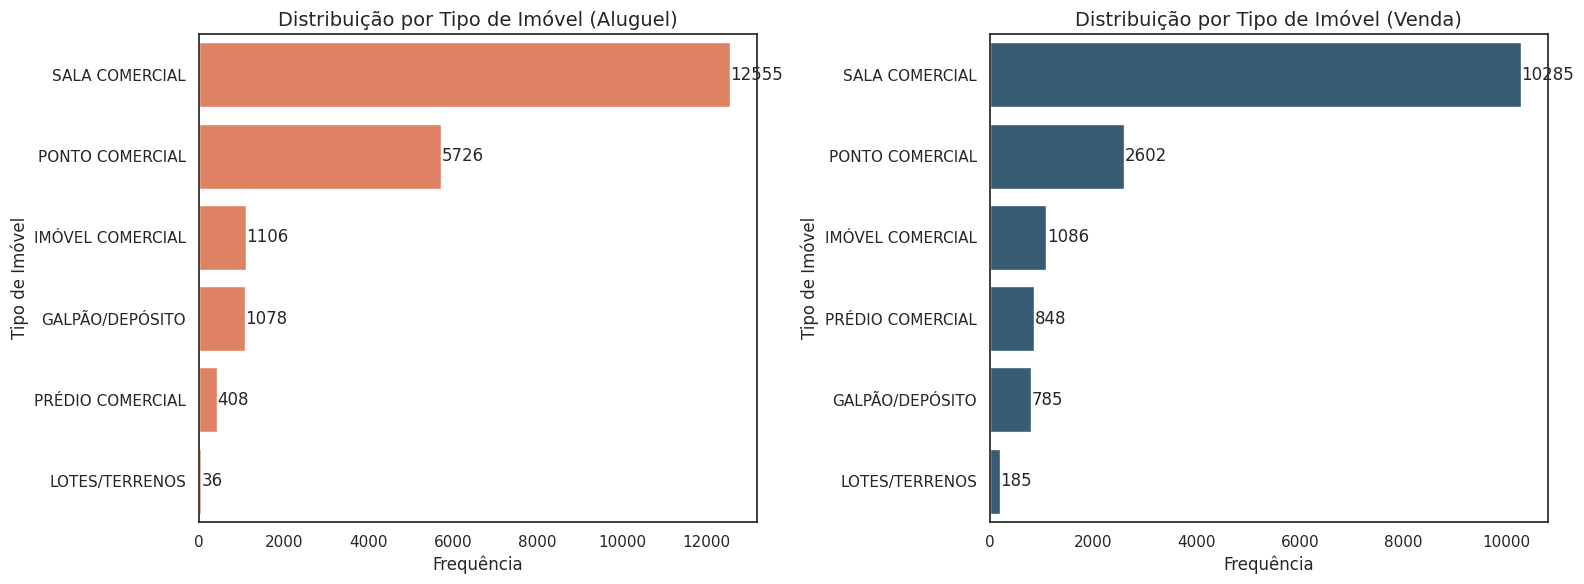

In [90]:

# Configuração geral para estilo e layout
sns.set(style="white")


# 1. Distribuição por Tipo de Imóvel para Rental
dist_tipo_rental = dados_rental_filtrado['imovel'].value_counts()

# 2. Distribuição por Tipo de Imóvel para Sale
dist_tipo_sale = dados_sale_filtrado['imovel'].value_counts()

# Criar subplots para exibir os gráficos lado a lado
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Distribuição por Tipo de Imóvel (Rental)
sns.barplot(x=dist_tipo_rental.values, y=dist_tipo_rental.index, ax=axes[0], color="#f4774f")
axes[0].set_title('Distribuição por Tipo de Imóvel (Aluguel)', fontsize=14)
axes[0].set_xlabel('Frequência', fontsize=12)
axes[0].set_ylabel('Tipo de Imóvel', fontsize=12)

# Adicionar valores absolutos nas barras do gráfico Rental
for index, value in enumerate(dist_tipo_rental.values):
    axes[0].text(value + 10, index, str(value), va='center')

# Gráfico 2: Distribuição por Tipo de Imóvel (Sale)
sns.barplot(x=dist_tipo_sale.values, y=dist_tipo_sale.index, ax=axes[1], color="#2d5f7d")
axes[1].set_title('Distribuição por Tipo de Imóvel (Venda)', fontsize=14)
axes[1].set_xlabel('Frequência', fontsize=12)
axes[1].set_ylabel('Tipo de Imóvel', fontsize=12)

# Adicionar valores absolutos nas barras do gráfico Sale
for index, value in enumerate(dist_tipo_sale.values):
    axes[1].text(value + 10, index, str(value), va='center')

# Ajustar o layout dos gráficos
plt.tight_layout()
plt.show()

## 6.4 Distribuição de Preço, Área e Preço do Metro Quadrado:

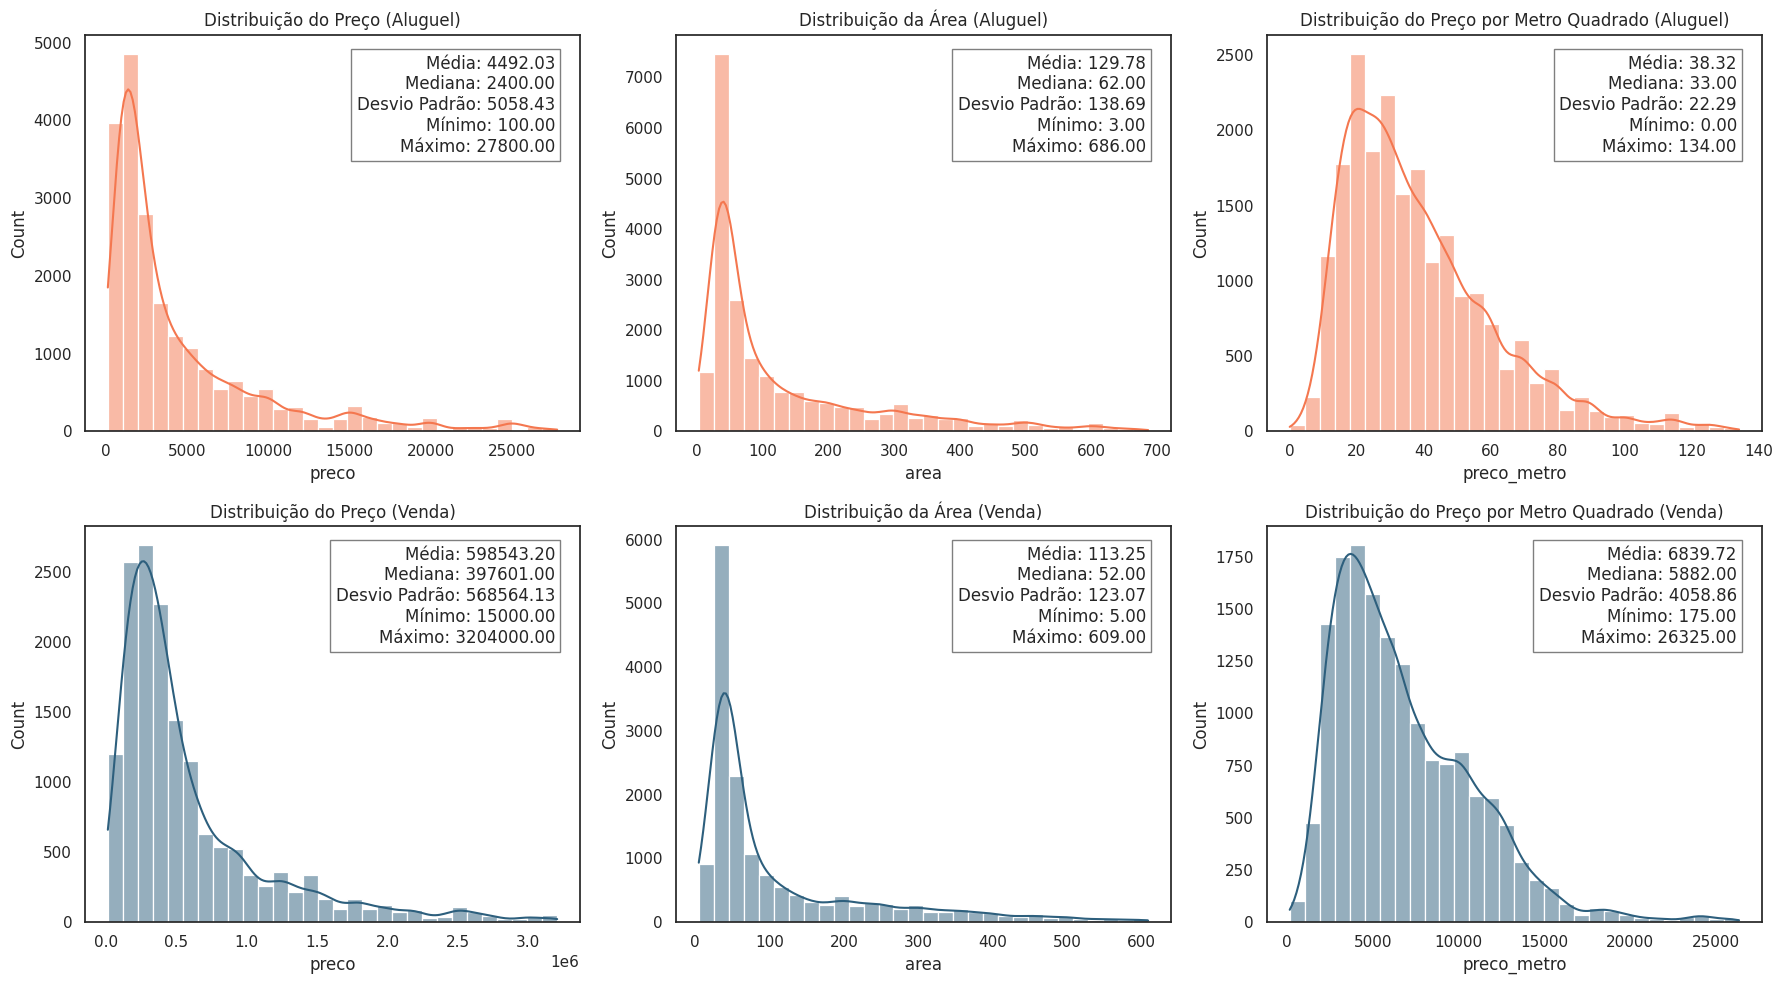

In [91]:
# Configuração geral do estilo
sns.set(style="white")

# Criar os gráficos e eixos
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Função para adicionar estatísticas (média, mediana, desvio padrão, mínimo, máximo) nos gráficos
def adicionar_estatisticas(ax, data, variavel):
    media = data[variavel].mean()
    mediana = data[variavel].median()
    desvio_padrao = data[variavel].std()
    minimo = data[variavel].min()
    maximo = data[variavel].max()

    # Texto a ser exibido no gráfico
    stat_text = (f'Média: {media:.2f}\nMediana: {mediana:.2f}\n'
                 f'Desvio Padrão: {desvio_padrao:.2f}\n'
                 f'Mínimo: {minimo:.2f}\nMáximo: {maximo:.2f}')

    # Adicionar o texto no gráfico
    ax.text(0.95, 0.95, stat_text, transform=ax.transAxes, verticalalignment='top',
            horizontalalignment='right', bbox=dict(facecolor='white', edgecolor='black', alpha=0.5))

# Gráficos para Rental após remoção de outliers
sns.histplot(dados_rental_filtrado['preco'], bins=30, kde=True, ax=axes[0, 0], color="#f4774f")
axes[0, 0].set_title('Distribuição do Preço (Aluguel)')
adicionar_estatisticas(axes[0, 0], dados_rental_filtrado, 'preco')

sns.histplot(dados_rental_filtrado['area'], bins=30, kde=True, ax=axes[0, 1], color="#f4774f")
axes[0, 1].set_title('Distribuição da Área (Aluguel)')
adicionar_estatisticas(axes[0, 1], dados_rental_filtrado, 'area')

sns.histplot(dados_rental_filtrado['preco_metro'], bins=30, kde=True, ax=axes[0, 2], color="#f4774f")
axes[0, 2].set_title('Distribuição do Preço por Metro Quadrado (Aluguel)')
adicionar_estatisticas(axes[0, 2], dados_rental_filtrado, 'preco_metro')

# Gráficos para Sale após remoção de outliers
sns.histplot(dados_sale_filtrado['preco'], bins=30, kde=True, ax=axes[1, 0], color="#2d5f7d")
axes[1, 0].set_title('Distribuição do Preço (Venda)')
adicionar_estatisticas(axes[1, 0], dados_sale_filtrado, 'preco')

sns.histplot(dados_sale_filtrado['area'], bins=30, kde=True, ax=axes[1, 1], color="#2d5f7d")
axes[1, 1].set_title('Distribuição da Área (Venda)')
adicionar_estatisticas(axes[1, 1], dados_sale_filtrado, 'area')

sns.histplot(dados_sale_filtrado['preco_metro'], bins=30, kde=True, ax=axes[1, 2], color="#2d5f7d")
axes[1, 2].set_title('Distribuição do Preço por Metro Quadrado (Venda)')
adicionar_estatisticas(axes[1, 2], dados_sale_filtrado, 'preco_metro')

# Ajustar o layout
plt.tight_layout()
plt.show()


In [92]:
# Selecionar as colunas relevantes para a análise
variaveis = ['preco', 'area', 'preco_metro']
grupo = 'imovel'

# Função para calcular as estatísticas descritivas para cada tipo de imóvel
def calcular_estatisticas(df, grupo, variaveis):
    estatisticas = {}
    for var in variaveis:
        estatisticas[var] = df.groupby(grupo)[var].agg(
            media=('mean'),
            mediana=('median'),
            desvio_padrao=('std'),
            minimo=('min'),
            maximo=('max')
        )
    # Combinar todas as estatísticas em um único DataFrame
    resultado = pd.concat(estatisticas, axis=1)
    resultado.columns = ['_'.join(col).strip() for col in resultado.columns.values]
    return resultado

# Calcular as estatísticas descritivas
estatisticas_por_imovel = calcular_estatisticas(dados_rental_filtrado, grupo, variaveis)

# Exibir o resultado
print("Estatísticas descritivas por tipo de imóvel:")
print(tabulate(estatisticas_por_imovel, headers='keys', tablefmt='pretty'))

estatisticas_por_imovel.to_excel('estatisticas_por_imovel_rental.xlsx')


Estatísticas descritivas por tipo de imóvel:
+------------------+--------------------+---------------+---------------------+--------------+--------------+--------------------+--------------+--------------------+-------------+-------------+--------------------+---------------------+---------------------------+--------------------+--------------------+
|      imovel      |    preco_media     | preco_mediana | preco_desvio_padrao | preco_minimo | preco_maximo |     area_media     | area_mediana | area_desvio_padrao | area_minimo | area_maximo | preco_metro_media  | preco_metro_mediana | preco_metro_desvio_padrao | preco_metro_minimo | preco_metro_maximo |
+------------------+--------------------+---------------+---------------------+--------------+--------------+--------------------+--------------+--------------------+-------------+-------------+--------------------+---------------------+---------------------------+--------------------+--------------------+
| GALPÃO/DEPÓSITO  | 6346.36641

In [93]:
# Selecionar as colunas relevantes para a análise
variaveis = ['preco', 'area', 'preco_metro']
grupo = 'imovel'

# Função para calcular as estatísticas descritivas para cada tipo de imóvel
def calcular_estatisticas(df, grupo, variaveis):
    estatisticas = {}
    for var in variaveis:
        estatisticas[var] = df.groupby(grupo)[var].agg(
            media=('mean'),
            mediana=('median'),
            desvio_padrao=('std'),
            minimo=('min'),
            maximo=('max')
        )
    # Combinar todas as estatísticas em um único DataFrame
    resultado = pd.concat(estatisticas, axis=1)
    resultado.columns = ['_'.join(col).strip() for col in resultado.columns.values]
    return resultado

# Calcular as estatísticas descritivas
estatisticas_por_imovel = calcular_estatisticas(dados_sale_filtrado, grupo, variaveis)

# Exibir o resultado
print("Estatísticas descritivas por tipo de imóvel:")
print(tabulate(estatisticas_por_imovel, headers='keys', tablefmt='pretty'))

estatisticas_por_imovel.to_excel('estatisticas_por_imovel_sale.xlsx')


Estatísticas descritivas por tipo de imóvel:
+------------------+--------------------+---------------+---------------------+--------------+--------------+--------------------+--------------+--------------------+-------------+-------------+--------------------+---------------------+---------------------------+--------------------+--------------------+
|      imovel      |    preco_media     | preco_mediana | preco_desvio_padrao | preco_minimo | preco_maximo |     area_media     | area_mediana | area_desvio_padrao | area_minimo | area_maximo | preco_metro_media  | preco_metro_mediana | preco_metro_desvio_padrao | preco_metro_minimo | preco_metro_maximo |
+------------------+--------------------+---------------+---------------------+--------------+--------------+--------------------+--------------+--------------------+-------------+-------------+--------------------+---------------------+---------------------------+--------------------+--------------------+
| GALPÃO/DEPÓSITO  | 916853.231

### 6.5 Correlação entre área e preço do metro quadrado:

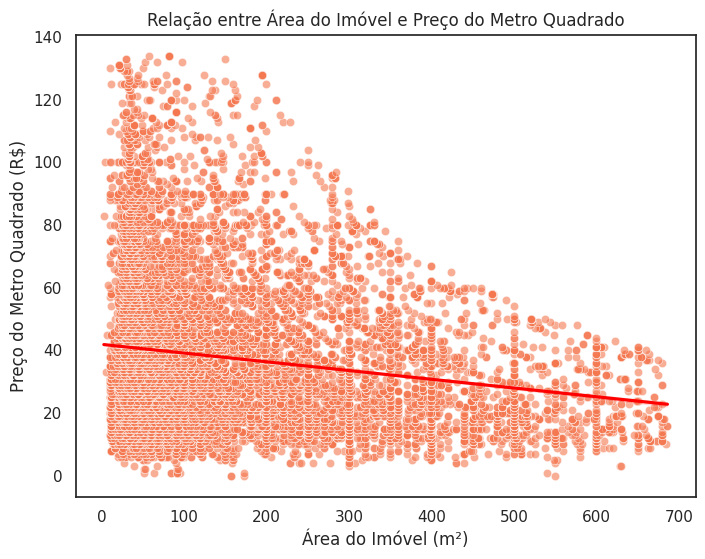

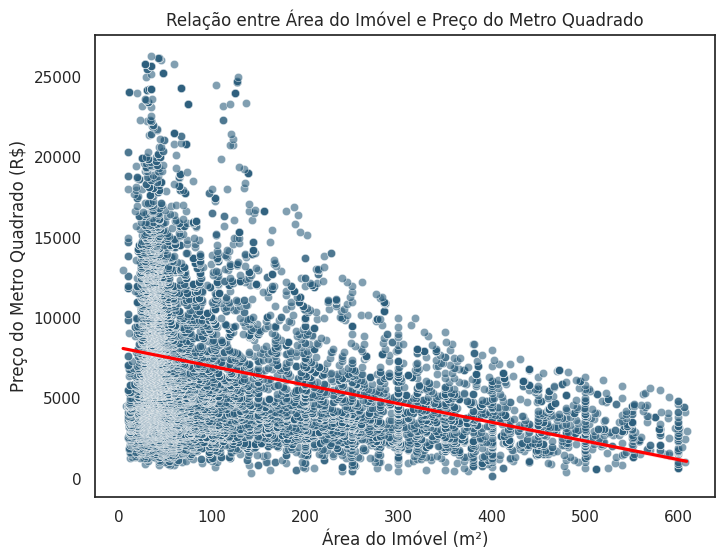

In [94]:
# Plotando scatter plot entre área do imóvel e preço do metro quadrado
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area', y='preco_metro', data=dados_rental_filtrado, alpha=0.6, color="#f4774f")

# Adicionar linha de tendência para melhor visualização
sns.regplot(x='area', y='preco_metro', data=dados_rental_filtrado, scatter=False, color='red')

# Títulos e legendas
plt.title("Relação entre Área do Imóvel e Preço do Metro Quadrado")
plt.xlabel("Área do Imóvel (m²)")
plt.ylabel("Preço do Metro Quadrado (R$)")
plt.show()


# Plotando scatter plot entre área do imóvel e preço do metro quadrado
plt.figure(figsize=(8, 6))
sns.scatterplot(x='area', y='preco_metro', data=dados_sale_filtrado, alpha=0.6, color="#2d5f7d")

# Adicionar linha de tendência para melhor visualização
sns.regplot(x='area', y='preco_metro', data=dados_sale_filtrado, scatter=False, color='red')

# Títulos e legendas
plt.title("Relação entre Área do Imóvel e Preço do Metro Quadrado")
plt.xlabel("Área do Imóvel (m²)")
plt.ylabel("Preço do Metro Quadrado (R$)")
plt.show()

# 7: Análises Geográficas:

## 7.1: Desenho dos Bairros de Porto Alegre:

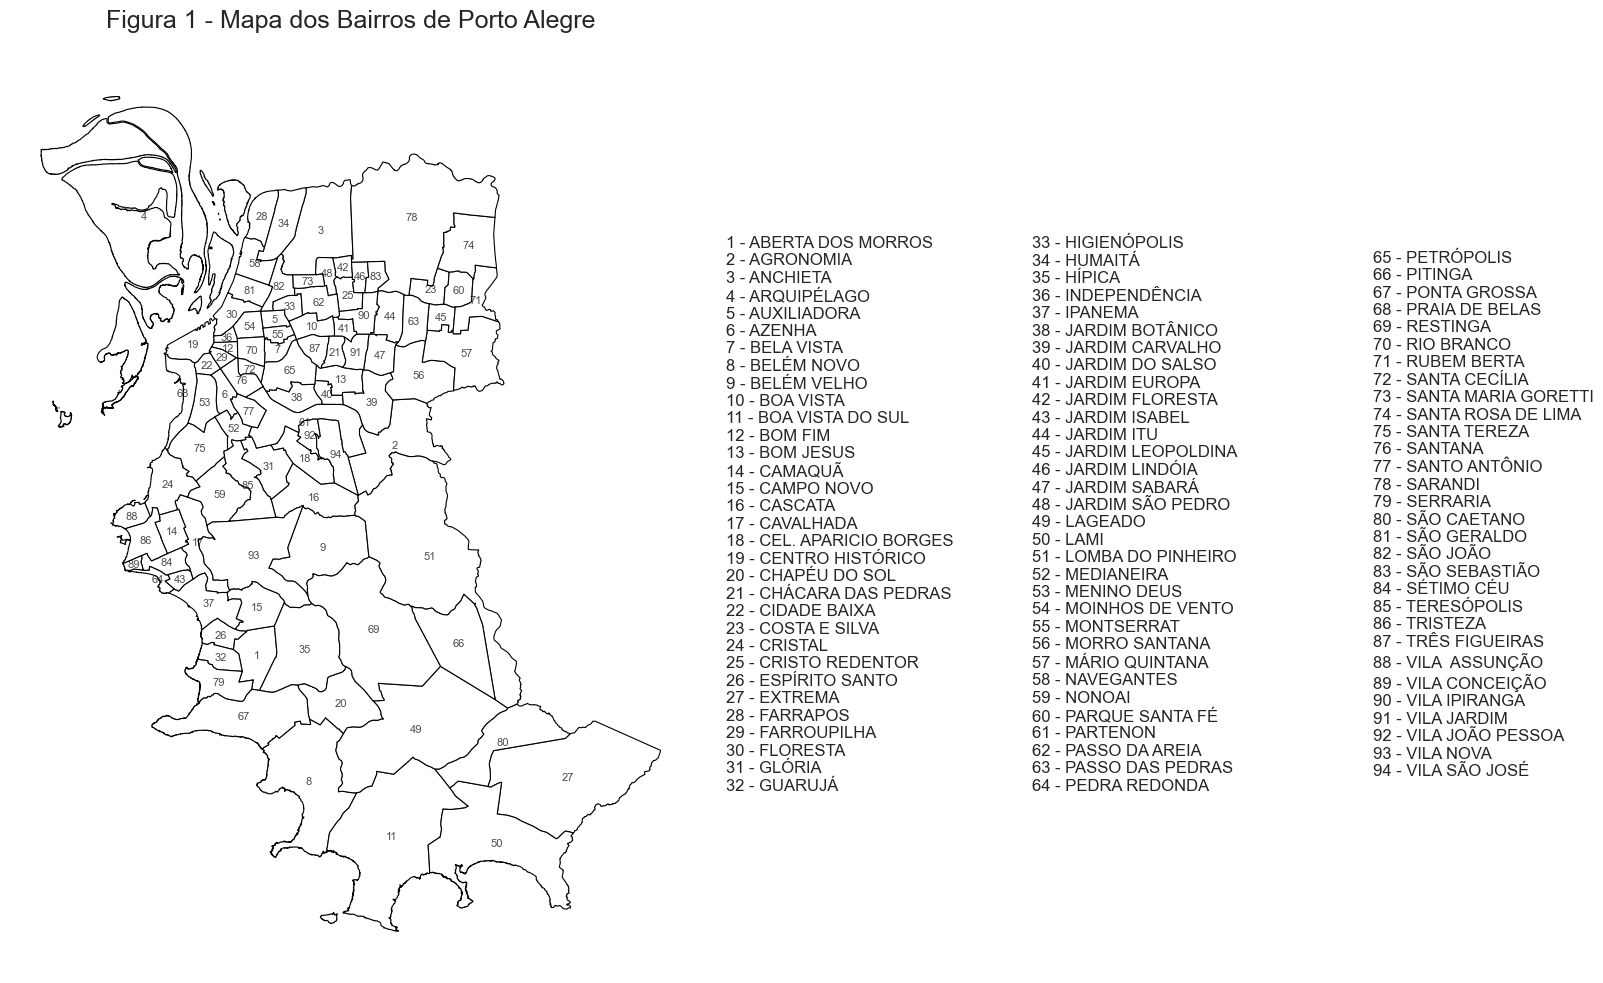

In [95]:
import math
import matplotlib.pyplot as plt
from matplotlib import font_manager

# Fonte Arial
font_path = '/content/drive/My Drive/EDA - imobiliario porto alegre/fontes/arial.ttf'  # Ajuste o caminho conforme necessário
arial_font = font_manager.FontProperties(fname=font_path, size=12)

csfont = {'fontname':'Arial'}


# Agrupar os polígonos por bairro
bairros_shapefile_agrupado = bairros_shapefile.dissolve(by='bairro', as_index=False)

# Calcular o centroide para cada bairro agrupado
bairros_shapefile_agrupado['centroid'] = bairros_shapefile_agrupado.geometry.centroid

# Criar uma lista de correspondência entre números e nomes dos bairros
bairro_list = list(bairros_shapefile_agrupado['bairro'])
num_bairros = range(1, len(bairro_list) + 1)  # Numerar os bairros a partir de 1

# Adicionar a numeração ao GeoDataFrame para plotar no mapa
bairros_shapefile_agrupado['num'] = num_bairros

# Configurar o número de colunas desejado para a legenda
n_colunas = 3
bairros_por_coluna = math.ceil(len(bairro_list) / n_colunas)  # Bairros por coluna
colunas = [bairro_list[i:i + bairros_por_coluna] for i in range(0, len(bairro_list), bairros_por_coluna)]
numeros_por_coluna = [list(num_bairros)[i:i + bairros_por_coluna] for i in range(0, len(num_bairros), bairros_por_coluna)]

# Configurar o tamanho do gráfico
fig, ax = plt.subplots(1, 1, figsize=(12, 10))

# Ajustar o espaçamento geral do gráfico
plt.subplots_adjust(top=0.85)  # Espaço acima do título, ajuste conforme necessário

# Plotar os bairros com fundo branco e bordas pretas
bairros_shapefile_agrupado.plot(ax=ax, edgecolor='black', facecolor='white', linewidth=0.8)

# Adicionar os números dos bairros nos centroides
for idx, row in bairros_shapefile_agrupado.iterrows():
    ax.text(
        row['centroid'].x,
        row['centroid'].y,
        str(row['num']),  # Mostrar o número do bairro
        fontsize=8,
        ha='center',
        va='center',
        color='black',
        alpha=0.7,
        fontproperties=arial_font
    )

# Posicionar as colunas lado a lado
col_x_positions = [1.05, 1.5, 2]  # Ajuste espaçamento horizontal
for col, x_pos, nums in zip(colunas, col_x_positions, numeros_por_coluna):
    col_texto = "\n".join([f"{num} - {bairro}" for num, bairro in zip(nums, col)])
    fig.text(x_pos, 0.5, col_texto, fontproperties=arial_font, va='center', transform=ax.transAxes)

# Remover os eixos
ax.axis('off')

# Adicionar título ajustado
plt.title("Figura 1 - Mapa dos Bairros de Porto Alegre", fontproperties=arial_font, **csfont,  fontsize=18, pad=20)

# Ajustar layout
plt.tight_layout()
plt.show()



## 7.2: Junção dos dados de anúncios com a base de shapefile dos bairros:

In [96]:
# 1. Agregar contagem de imóveis por bairro (aluguel e venda separados)
contagem_aluguel = dados_rental_filtrado.groupby('bairro').size().reset_index(name='contagem_aluguel')
contagem_venda = dados_sale_filtrado.groupby('bairro').size().reset_index(name='contagem_venda')

# 2. Agregar preço médio por metro quadrado por bairro
preco_m2_aluguel = dados_rental_filtrado.groupby('bairro')['preco_metro'].mean().reset_index(name='preco_m2_aluguel')
preco_m2_venda = dados_sale_filtrado.groupby('bairro')['preco_metro'].mean().reset_index(name='preco_m2_venda')

# 3. Diferença de preço médio entre aluguel e venda por bairro
preco_medio_aluguel = dados_rental_filtrado.groupby('bairro')['preco'].mean().reset_index(name='preco_medio_aluguel')
preco_medio_venda = dados_sale_filtrado.groupby('bairro')['preco'].mean().reset_index(name='preco_medio_venda')

# Calcular a diferença de preço médio
diferenca_preco = preco_medio_aluguel.merge(preco_medio_venda, on='bairro', how='outer')
diferenca_preco['diferenca_preco'] = diferenca_preco['preco_medio_venda'] - diferenca_preco['preco_medio_aluguel']

# 4. Proporção de tipos de imóvel por bairro (separado por aluguel e venda)
proporcao_tipo_imovel_aluguel = dados_rental_filtrado.groupby(['bairro', 'imovel']).size().unstack(fill_value=0)
proporcao_tipo_imovel_aluguel = proporcao_tipo_imovel_aluguel.div(proporcao_tipo_imovel_aluguel.sum(axis=1), axis=0)
proporcao_tipo_imovel_aluguel = proporcao_tipo_imovel_aluguel.reset_index()

proporcao_tipo_imovel_venda = dados_sale_filtrado.groupby(['bairro', 'imovel']).size().unstack(fill_value=0)
proporcao_tipo_imovel_venda = proporcao_tipo_imovel_venda.div(proporcao_tipo_imovel_venda.sum(axis=1), axis=0)
proporcao_tipo_imovel_venda = proporcao_tipo_imovel_venda.reset_index()

# Consolidar todas as informações no shapefile
# Merge contagens
bairros_shapefile = bairros_shapefile.merge(contagem_aluguel, on='bairro', how='left')
bairros_shapefile = bairros_shapefile.merge(contagem_venda, on='bairro', how='left')

# Merge preços médios por metro quadrado
bairros_shapefile = bairros_shapefile.merge(preco_m2_aluguel, on='bairro', how='left')
bairros_shapefile = bairros_shapefile.merge(preco_m2_venda, on='bairro', how='left')

# Merge diferença de preços
bairros_shapefile = bairros_shapefile.merge(diferenca_preco[['bairro', 'diferenca_preco']], on='bairro', how='left')

# Merge proporção de tipos de imóvel
bairros_shapefile = bairros_shapefile.merge(proporcao_tipo_imovel_aluguel, on='bairro', how='left', suffixes=('_aluguel', ''))
bairros_shapefile = bairros_shapefile.merge(proporcao_tipo_imovel_venda, on='bairro', how='left', suffixes=('', '_venda'))

In [97]:
print(bairros_shapefile.head())

   OBJECTID  CODIGO            bairro EDITOR DATA_EDICA  GEOM_AREA  GEOM_LEN  \
0      1281       0  PASSO DAS PEDRAS   None 2016-10-20        0.0       0.0   
1      1282       0      HIGIENÓPOLIS   None 2016-10-20        0.0       0.0   
2      1283       0     VILA IPIRANGA   None 2016-10-20        0.0       0.0   
3      1288       0   PARQUE SANTA FÉ   None 2016-10-20        0.0       0.0   
4      1289       0     COSTA E SILVA   None 2016-10-20        0.0       0.0   

                                            geometry  contagem_aluguel  \
0  POLYGON ((287595.213 1678609.133, 287635.971 1...               5.0   
1  POLYGON ((282819.328 1677715.723, 282809.697 1...             191.0   
2  POLYGON ((285882.786 1676864.358, 285806.568 1...              96.0   
3  POLYGON ((290475.978 1679356.214, 290477.321 1...               7.0   
4  POLYGON ((289403.688 1679659.969, 289400.081 1...              12.0   

   contagem_venda  ...  LOTES/TERRENOS  PONTO COMERCIAL  PRÉDIO COMERCIAL 

In [98]:
print(bairros_shapefile.shape)

(128, 25)


## 7.3: Quantidade de imóveis ofertados para aluguel e venda por bairro:

<ipython-input-99-09fa124e7bbd>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout


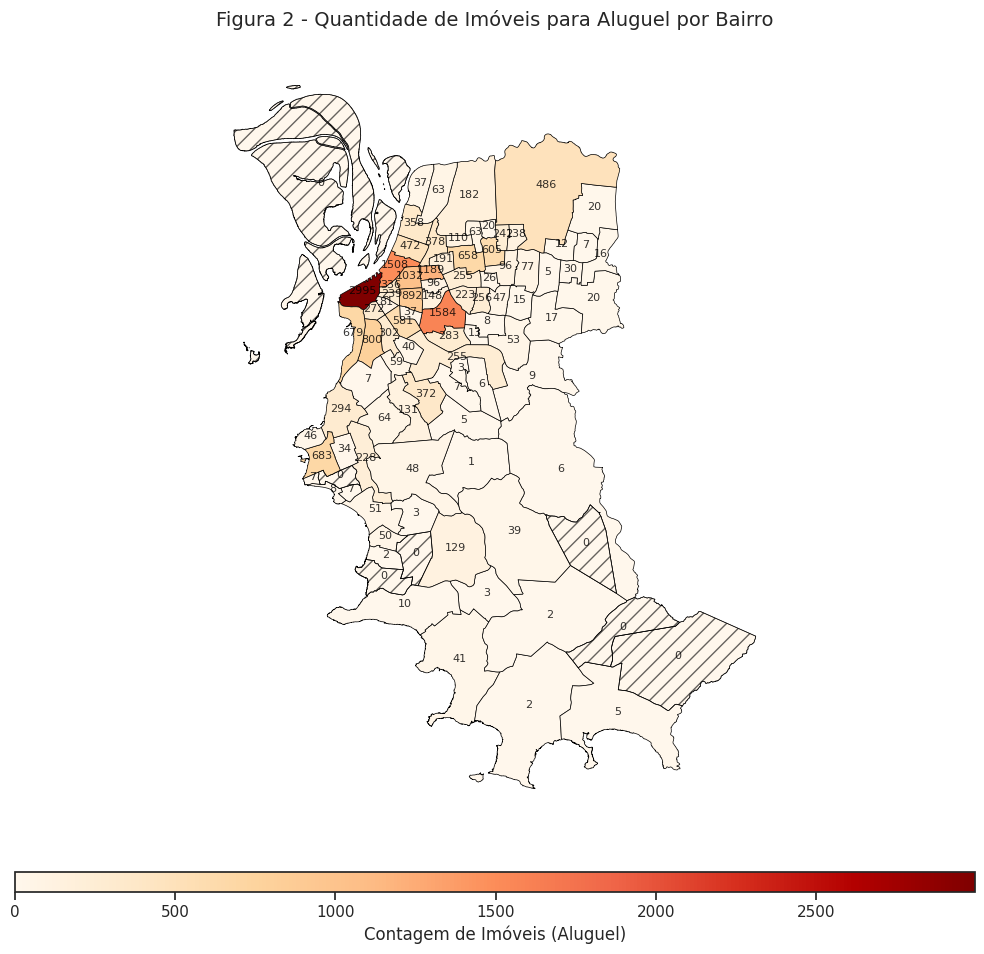

<ipython-input-99-09fa124e7bbd>:65: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout


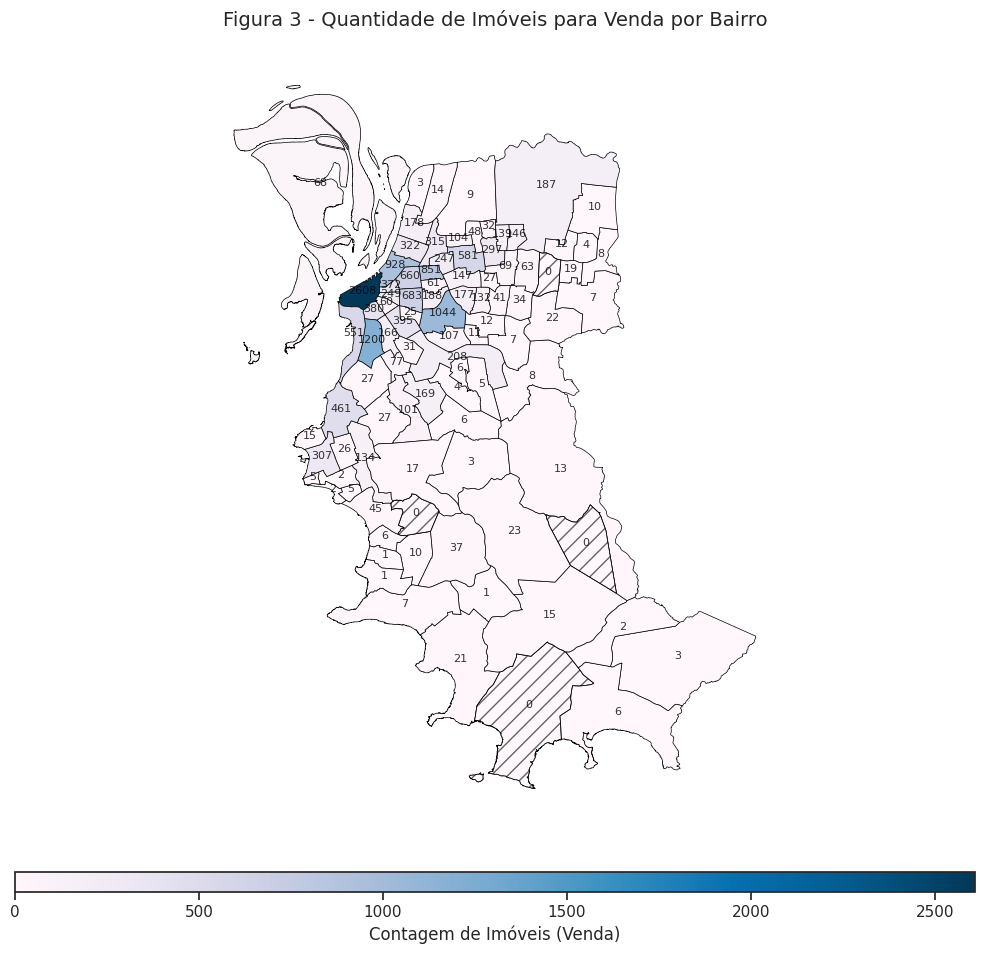

In [99]:
# Agrupar os polígonos por bairro (dissolver)
bairros_shapefile_agrupado = bairros_shapefile.dissolve(by='bairro')

# Adicionar contagem de imóveis (aluguel e venda) no shapefile agrupado
bairros_shapefile_agrupado['contagem_aluguel'] = bairros_shapefile.groupby('bairro')['contagem_aluguel'].sum()
bairros_shapefile_agrupado['contagem_venda'] = bairros_shapefile.groupby('bairro')['contagem_venda'].sum()

# Normalização para as colorbars
norm_aluguel = Normalize(vmin=bairros_shapefile_agrupado['contagem_aluguel'].min(),
                         vmax=bairros_shapefile_agrupado['contagem_aluguel'].max())
norm_venda = Normalize(vmin=bairros_shapefile_agrupado['contagem_venda'].min(),
                       vmax=bairros_shapefile_agrupado['contagem_venda'].max())

# Primeiro mapa: Aluguel
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
bairros_shapefile_agrupado.plot(
    column='contagem_aluguel', cmap='OrRd', ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title('Figura 2 - Quantidade de Imóveis para Aluguel por Bairro', fontsize=14)

# Destacar bairros com 0 imóveis no mapa de aluguel
bairros_shapefile_agrupado[bairros_shapefile_agrupado['contagem_aluguel'] == 0].plot(
    ax=ax, edgecolor='black', facecolor='none', hatch='//', linewidth=0.5, alpha=0.6)

# Adicionar os rótulos com os valores de contagem de aluguel
for idx, row in bairros_shapefile_agrupado.iterrows():
    valor = 0 if pd.isna(row['contagem_aluguel']) else int(row['contagem_aluguel'])
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, valor, fontsize=8, ha='center', color='black', alpha=0.8)

ax.axis('off')  # Remover eixos

# Adicionar escala de cores
cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [esquerda, inferior, largura, altura]
sm = cm.ScalarMappable(cmap='OrRd', norm=norm_aluguel)
sm._A = []  # Necessário para configurar a colorbar
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Contagem de Imóveis (Aluguel)')

plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout
plt.show()

# Segundo mapa: Venda
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
bairros_shapefile_agrupado.plot(
    column='contagem_venda', cmap='PuBu', ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title('Figura 3 - Quantidade de Imóveis para Venda por Bairro', fontsize=14)

# Destacar bairros com 0 imóveis no mapa de venda
bairros_shapefile_agrupado[bairros_shapefile_agrupado['contagem_venda'] == 0].plot(
    ax=ax, edgecolor='black', facecolor='none', hatch='//', linewidth=0.5, alpha=0.6)

# Adicionar os rótulos com os valores de contagem de venda
for idx, row in bairros_shapefile_agrupado.iterrows():
    valor = 0 if pd.isna(row['contagem_venda']) else int(row['contagem_venda'])
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, valor, fontsize=8, ha='center', color='black', alpha=0.8)

ax.axis('off')  # Remover eixos

# Adicionar escala de cores
cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [esquerda, inferior, largura, altura]
sm = cm.ScalarMappable(cmap='PuBu', norm=norm_venda)
sm._A = []  # Necessário para configurar a colorbar
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Contagem de Imóveis (Venda)')

plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout
plt.show()



## 7.4: Distribuição dos Tipos de Imóvel pela Cidade:

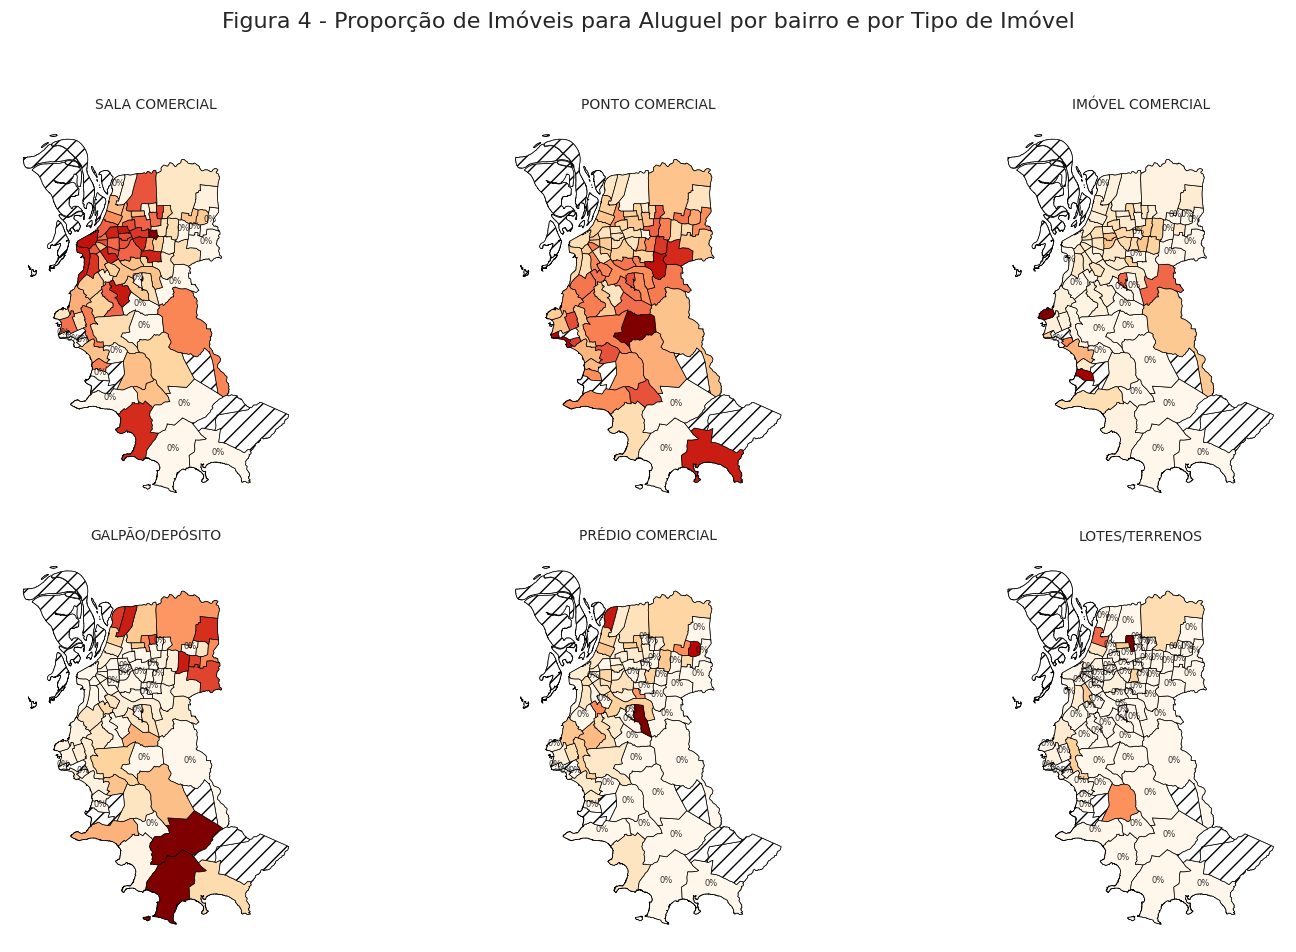

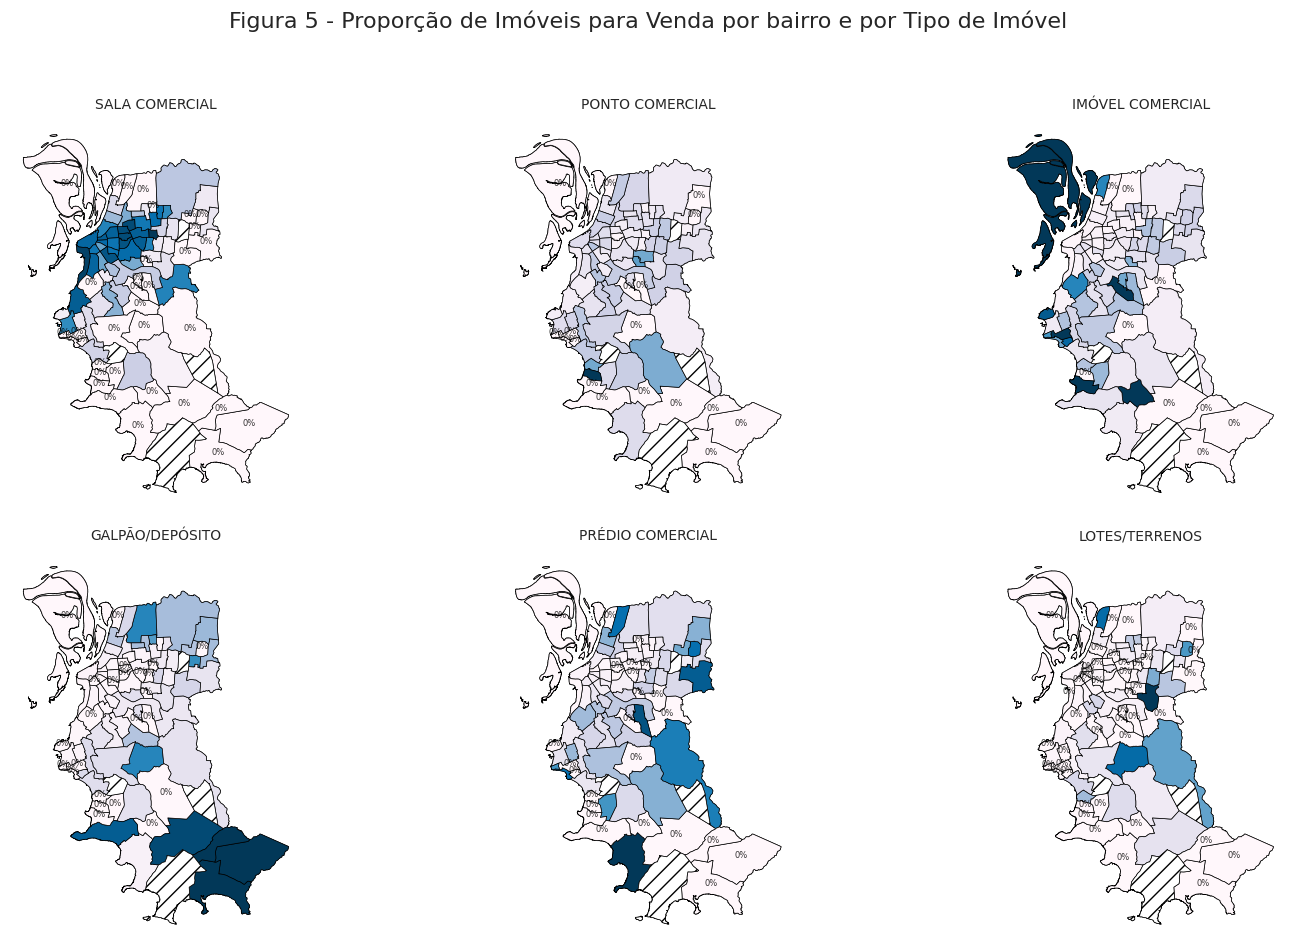

In [100]:
# Função para criar mapas por tipo de imóvel, desenhando todos os bairros
def criar_mapa_por_tipo_zero(ax, tipo_imovel, coluna, cmap, titulo):
    # Plotar o mapa base de todos os bairros em branco
    bairros_shapefile_agrupado.plot(ax=ax, facecolor='white', edgecolor='black', linewidth=0.5)

    # Plotar os dados sobrepostos com a coluna específica
    bairros_shapefile_agrupado.plot(
        column=coluna,
        cmap=cmap,
        ax=ax,
        edgecolor='black',
        linewidth=0.5,
        missing_kwds={"color": "white", "edgecolor": "black", "hatch": "//"}  # Desenhar áreas sem dados com hachura
    )

    ax.set_title(titulo, fontsize=10)

    # Adicionar rótulos apenas nos bairros com 0 imóveis
    for idx, row in bairros_shapefile_agrupado.iterrows():
        valor = row[coluna]
        if not pd.isna(valor) and valor == 0:  # Exibir apenas se o valor for exatamente 0
            centroid = row['geometry'].centroid  # Posição do texto
            ax.text(centroid.x, centroid.y, "0%", fontsize=6, ha='center', color='black', alpha=0.8)

    ax.axis('off')  # Remover os eixos


# Configurações de cores e títulos para os tipos de imóvel
tipos_imoveis = ['SALA COMERCIAL', 'PONTO COMERCIAL', 'IMÓVEL COMERCIAL',
                 'GALPÃO/DEPÓSITO', 'PRÉDIO COMERCIAL', 'LOTES/TERRENOS']
cmap_venda = 'PuBu'
cmap_aluguel = 'OrRd'

# Criar figura para imóveis de aluguel
fig_aluguel, axes_aluguel = plt.subplots(2, 3, figsize=(16, 10))
fig_aluguel.suptitle('Figura 4 - Proporção de Imóveis para Aluguel por bairro e por Tipo de Imóvel', fontsize=16)

for idx, tipo_imovel in enumerate(tipos_imoveis):
    row, col = divmod(idx, 3)
    criar_mapa_por_tipo_zero(
        ax=axes_aluguel[row, col],
        tipo_imovel=tipo_imovel,
        coluna=f'{tipo_imovel}',  # Nome das colunas de aluguel
        cmap=cmap_aluguel,
        titulo=f'{tipo_imovel}'
    )

# Ajustar layout da figura de aluguel
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Criar figura para imóveis de venda
fig_venda, axes_venda = plt.subplots(2, 3, figsize=(16, 10))
fig_venda.suptitle('Figura 5 - Proporção de Imóveis para Venda por bairro e por Tipo de Imóvel', fontsize=16)

for idx, tipo_imovel in enumerate(tipos_imoveis):
    row, col = divmod(idx, 3)
    criar_mapa_por_tipo_zero(
        ax=axes_venda[row, col],
        tipo_imovel=tipo_imovel,
        coluna=f'{tipo_imovel}_venda',  # Nome das colunas de venda
        cmap=cmap_venda,
        titulo=f'{tipo_imovel}'
    )

# Ajustar layout da figura de venda
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()



## 7.5: Preço médio para aluguel e venda por Bairro:

<ipython-input-101-a78791cc3fa8>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout


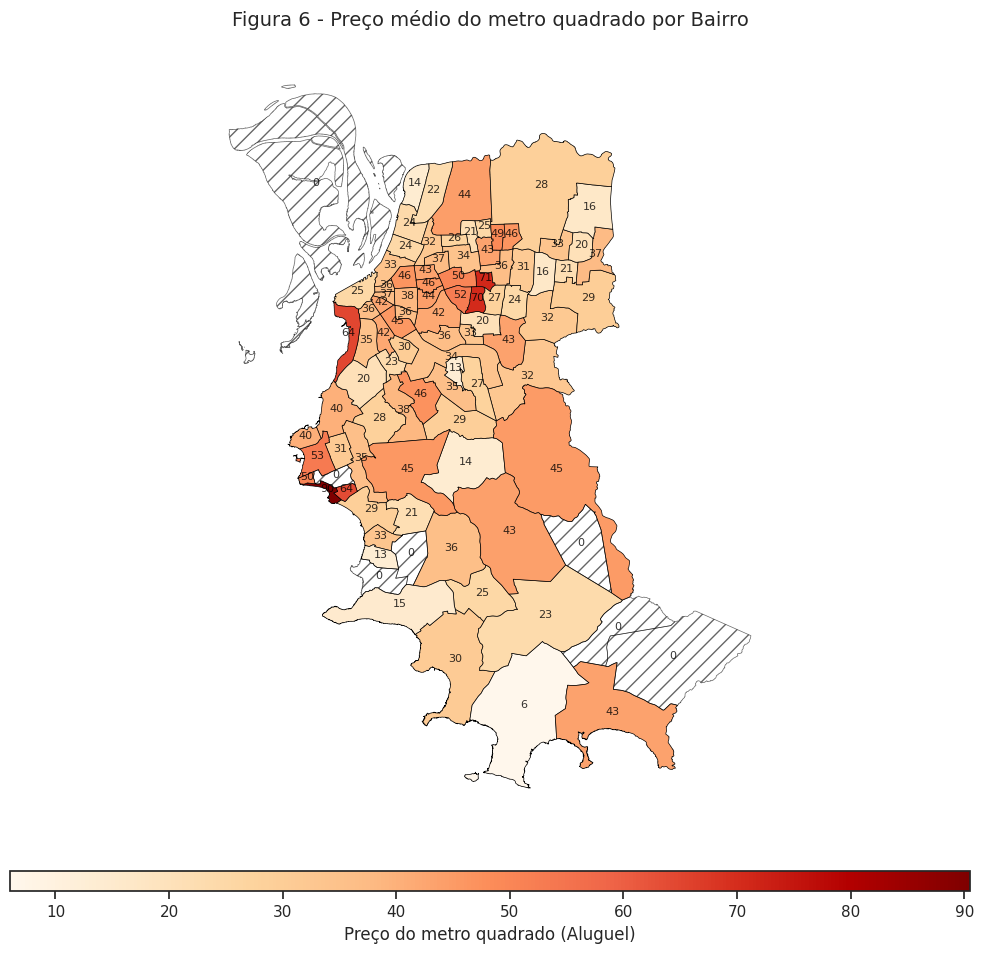

<ipython-input-101-a78791cc3fa8>:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout


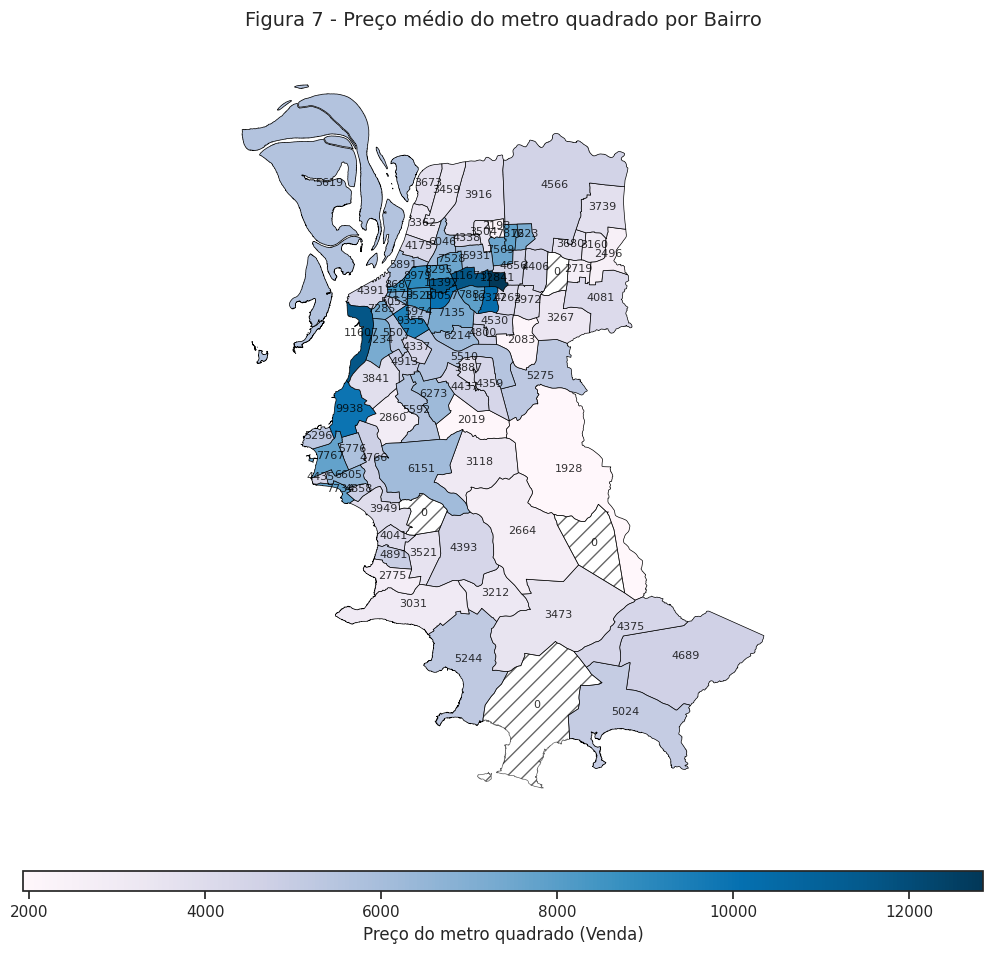

In [101]:
# Normalização para as colorbars
norm_aluguel = Normalize(vmin=bairros_shapefile_agrupado['preco_m2_aluguel'].min(),
                         vmax=bairros_shapefile_agrupado['preco_m2_aluguel'].max())
norm_venda = Normalize(vmin=bairros_shapefile_agrupado['preco_m2_venda'].min(),
                       vmax=bairros_shapefile_agrupado['preco_m2_venda'].max())

# Primeiro mapa: Aluguel
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
bairros_shapefile_agrupado.plot(
    column='preco_m2_aluguel', cmap='OrRd', ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title('Figura 6 - Preço médio do metro quadrado por Bairro', fontsize=14)

# Destacar bairros com 0 imóveis no mapa de aluguel
bairros_shapefile_agrupado[bairros_shapefile_agrupado['contagem_aluguel'] == 0].plot(
    ax=ax, edgecolor='black', facecolor='none', hatch='//', linewidth=0.5, alpha=0.6)

# Adicionar os rótulos com os valores de contagem de aluguel
for idx, row in bairros_shapefile_agrupado.iterrows():
    valor = 0 if pd.isna(row['preco_m2_aluguel']) else int(row['preco_m2_aluguel'])
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, valor, fontsize=8, ha='center', color='black', alpha=0.8)

ax.axis('off')  # Remover eixos

# Adicionar escala de cores
cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [esquerda, inferior, largura, altura]
sm = cm.ScalarMappable(cmap='OrRd', norm=norm_aluguel)
sm._A = []  # Necessário para configurar a colorbar
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Preço do metro quadrado (Aluguel)')

plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout
plt.show()

# Segundo mapa: Venda
fig, ax = plt.subplots(1, 1, figsize=(16, 10))
bairros_shapefile_agrupado.plot(
    column='preco_m2_venda', cmap='PuBu', ax=ax, edgecolor='black', linewidth=0.5)
ax.set_title('Figura 7 - Preço médio do metro quadrado por Bairro', fontsize=14)

# Destacar bairros com 0 imóveis no mapa de venda
bairros_shapefile_agrupado[bairros_shapefile_agrupado['contagem_venda'] == 0].plot(
    ax=ax, edgecolor='black', facecolor='none', hatch='//', linewidth=0.5, alpha=0.6)

# Adicionar os rótulos com os valores de contagem de venda
for idx, row in bairros_shapefile_agrupado.iterrows():
    valor = 0 if pd.isna(row['preco_m2_venda']) else int(row['preco_m2_venda'])
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, valor, fontsize=8, ha='center', color='black', alpha=0.8)

ax.axis('off')  # Remover eixos

# Adicionar escala de cores
cax = fig.add_axes([0.2, 0.1, 0.6, 0.02])  # [esquerda, inferior, largura, altura]
sm = cm.ScalarMappable(cmap='PuBu', norm=norm_venda)
sm._A = []  # Necessário para configurar a colorbar
fig.colorbar(sm, cax=cax, orientation='horizontal', label='Preço do metro quadrado (Venda)')

plt.tight_layout(rect=[0, 0.15, 1, 1])  # Ajustar layout
plt.show()



# 8: Testagem de Modelos Preditivos:


Variáveis Testadas:
  * área
  
  * tipo imóvel
  
  * densidade demográfica
  
  * quantidade domicilios
  
  * quantidade população
  
  * proporção rede geral de esgoto
  
  * rendimento nominal mensal percapita

  *quantidade de alvarás

### Funções para preparação dos dados e seleção de variáveis:

In [102]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Function to prepare data for OLS
def preparar_dados_ols(dados_imoveis, dados_bairros):
    # Create dummies for the 'imovel' variable
    dados_imoveis = pd.get_dummies(dados_imoveis, columns=['imovel'])

    # Merge with neighborhood data
    dados = dados_imoveis.merge(dados_bairros, how='left', left_on='bairro', right_on='Nome_do_bairro')

    # Select relevant variables
    dados = dados[['preco_metro', 'area'] + [col for col in dados if col.startswith('imovel_')] +
                  ['densidade_demografica', 'qnt_domicilios_2022', 'qnt_populacao_2022',
                   'proporcao_rede_geral_esgoto', 'rendimento_nominal_mensal_percapita_atual',
                   'quantidade_alvaras']]

    # Handle missing values
    dados = dados.dropna()

    return dados

# Função para selecionar variáveis significativas com p-valor < 0.06
def selecionar_variaveis_significativas(modelo, limite_p=0.06):
    variaveis_significativas = [var for var, p in modelo.pvalues.items() if p < limite_p]
    return variaveis_significativas
# Função para realizar Stepwise Forward Selection
def stepwise_forward_selection(X, y, significance_level=0.05):
    # Inicializar com variáveis intrínsecas já incluídas
    initial_features = ['area', 'imovel_num']  # Variáveis intrínsecas
    remaining_features = [col for col in X.columns if col not in initial_features]  # Excluir as intrínsecas
    selected_features = initial_features[:]  # Incluir diretamente as intrínsecas

    while remaining_features:
        p_values = {}
        for feature in remaining_features:
            features_to_test = selected_features + [feature]
            X_test = sm.add_constant(X[features_to_test])  # Adiciona constante
            model = sm.OLS(y, X_test).fit()
            p_values[feature] = model.pvalues[feature]

        # Selecionar a variável com menor p-valor
        best_feature = min(p_values, key=p_values.get)
        if p_values[best_feature] < significance_level:
            selected_features.append(best_feature)
            remaining_features.remove(best_feature)
            print(f"Selecionada: {best_feature} (p-value: {p_values[best_feature]:.4f})")
        else:
            break

    return selected_features



## 8.1: Modelo de Preços Hedonicos - Regressão Multipla:

### 8.1.1: Modelo para Aluguel:






In [103]:
# Carregar os dados
dados_imoveis = dados_rental_filtrado.copy()
dados_bairros = dados_bairros.copy()

# Preparar os dados
dados = preparar_dados_ols(dados_imoveis, dados_bairros)

# Dividir em X e y
X = dados.drop(columns=['preco_metro'])
y = dados['preco_metro']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as variáveis independentes
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Adicionar constante ao conjunto de treino
X_train_scaled_with_const = sm.add_constant(X_train_scaled, prepend=False)

# Ajustar o modelo inicial com todas as variáveis
modelo_ols_all = sm.OLS(y_train, X_train_scaled_with_const).fit()

# Exibir resumo do modelo com todas as variáveis
print("Modelo com Todas as Variáveis:")
print(modelo_ols_all.summary())

# Selecionar variáveis com p <= 0.06
variaveis_significativas = [var for var, pval in modelo_ols_all.pvalues.items() if pval <= 0.06 and var != 'const']
print("\nVariáveis Significativas (p <= 0.06):")
print(variaveis_significativas)

# Ajustar o modelo final com as variáveis significativas
X_train_significativas = sm.add_constant(X_train_scaled[variaveis_significativas])
X_test_significativas = sm.add_constant(X_test_scaled[variaveis_significativas])

modelo_ols_significativas = sm.OLS(y_train, X_train_significativas).fit()

# Exibir resumo do modelo com variáveis significativas
print("Modelo com Variáveis Significativas:")
print(modelo_ols_significativas.summary())



Modelo com Todas as Variáveis:
                            OLS Regression Results                            
Dep. Variable:            preco_metro   R-squared:                       0.177
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     300.1
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:00:13   Log-Likelihood:                -74028.
No. Observations:               16727   AIC:                         1.481e+05
Df Residuals:                   16714   BIC:                         1.482e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

#### Métricas de Erro:

Erro Médio Absoluto:

Raiz do Erro Quadrático Médio:

In [108]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as variáveis independentes
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Adicionar constante para o modelo OLS
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Ajustar o modelo OLS
modelo_ols = sm.OLS(y_train, X_train_scaled).fit()

# Obter previsões do modelo OLS
y_pred = modelo_ols.predict(X_test_scaled)

# Função para calcular métricas de erro
def calcular_metricas(y_test, y_pred):
    """
    Calcula e exibe as métricas de erro para o modelo.
    """
    # Erro Médio Absoluto (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Erro Médio Absoluto (MAE): {mae:.4f}")

    mse = mean_squared_error(y_test, y_pred)  # Calcular o MSE
    rmse = np.sqrt(mse)
    print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")

    return mae, rmse

# Calcular métricas
mae, rmse = calcular_metricas(y_test, y_pred)


Erro Médio Absoluto (MAE): 15.3475
Raiz do Erro Quadrático Médio (RMSE): 20.1844


### 8.1.2: Modelo para Venda:

In [110]:
# Carregar os dados
dados_imoveis = dados_sale_filtrado.copy()
dados_bairros = dados_bairros.copy()

# Preparar os dados
dados = preparar_dados_ols(dados_imoveis, dados_bairros)

# Dividir em X e y
X = dados.drop(columns=['preco_metro'])
y = dados['preco_metro']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as variáveis independentes
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Adicionar constante ao conjunto de treino
X_train_scaled_with_const = sm.add_constant(X_train_scaled, prepend=False)

# Ajustar o modelo inicial com todas as variáveis
modelo_ols_all = sm.OLS(y_train, X_train_scaled_with_const).fit()

# Exibir resumo do modelo com todas as variáveis
print("Modelo com Todas as Variáveis:")
print(modelo_ols_all.summary())

# Selecionar variáveis com p <= 0.06
variaveis_significativas = [var for var, pval in modelo_ols_all.pvalues.items() if pval <= 0.06 and var != 'const']
print("\nVariáveis Significativas (p <= 0.06):")
print(variaveis_significativas)

# Ajustar o modelo final com as variáveis significativas
X_train_significativas = sm.add_constant(X_train_scaled[variaveis_significativas])
X_test_significativas = sm.add_constant(X_test_scaled[variaveis_significativas])

modelo_ols_significativas = sm.OLS(y_train, X_train_significativas).fit()

# Exibir resumo do modelo com variáveis significativas
print("Modelo com Variáveis Significativas:")
print(modelo_ols_significativas.summary())

Modelo com Todas as Variáveis:
                            OLS Regression Results                            
Dep. Variable:            preco_metro   R-squared:                       0.249
Model:                            OLS   Adj. R-squared:                  0.248
Method:                 Least Squares   F-statistic:                     349.0
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:04:12   Log-Likelihood:            -1.2115e+05
No. Observations:               12632   AIC:                         2.423e+05
Df Residuals:                   12619   BIC:                         2.424e+05
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

#### Métricas de Erro:

Erro Médio Absoluto:

Raiz do Erro Quadrático Médio:

In [111]:
# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as variáveis independentes
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Adicionar constante para o modelo OLS
X_train_scaled = sm.add_constant(X_train_scaled)
X_test_scaled = sm.add_constant(X_test_scaled)

# Ajustar o modelo OLS
modelo_ols = sm.OLS(y_train, X_train_scaled).fit()

# Obter previsões do modelo OLS
y_pred = modelo_ols.predict(X_test_scaled)

# Função para calcular métricas de erro
def calcular_metricas(y_test, y_pred):
    """
    Calcula e exibe as métricas de erro para o modelo.
    """
    # Erro Médio Absoluto (MAE)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Erro Médio Absoluto (MAE): {mae:.4f}")

    mse = mean_squared_error(y_test, y_pred)  # Calcular o MSE
    rmse = np.sqrt(mse)
    print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")

    return mae, rmse

# Calcular métricas
mae, rmse = calcular_metricas(y_test, y_pred)

Erro Médio Absoluto (MAE): 2579.9258
Raiz do Erro Quadrático Médio (RMSE): 3363.4025


## 8.2: Modelagem Multinivel:

### Funções para preparação dos dados e seleção de variáveis:

In [112]:
# Função para preparar os dados para a modelagem multinível
def preparar_dados_multinivel(data_imoveis, data_bairros):
    """
    Prepara os dados para a modelagem multinível, incluindo normalização e codificação contínua dos tipos de imóvel.
    """
    # Selecionar as colunas relevantes
    data = data_imoveis[['preco_metro', 'area', 'imovel', 'bairro']].copy()

    # Codificar os tipos de imóvel com a média do preço por tipo
    tipo_imovel_mean = data.groupby('imovel')['preco_metro'].mean().to_dict()
    data['tipo_imovel_continuo'] = data['imovel'].map(tipo_imovel_mean)

    # Mesclar com os dados dos bairros
    data = data.merge(data_bairros, how='left', left_on='bairro', right_on='Nome_do_bairro')
    data.drop(columns=['Nome_do_bairro', 'imovel'], inplace=True)  # Remover colunas categóricas originais

    # Tratar valores nulos
    data.dropna(inplace=True)

    # Normalizar variáveis numéricas
    scaler = StandardScaler()
    cols_to_normalize = ['preco_metro', 'area', 'tipo_imovel_continuo', 'densidade_demografica',
                         'qnt_domicilios_2022', 'qnt_populacao_2022', 'proporcao_rede_geral_esgoto',
                         'rendimento_nominal_mensal_percapita_atual', 'quantidade_alvaras']
    data[cols_to_normalize] = scaler.fit_transform(data[cols_to_normalize])

    return data, scaler

# Função para calcular coeficientes e p-values de todas as variáveis
def calcular_pvalues_coeficientes(data, dependent_var, fixed_vars, candidate_vars, random_effect_var):
    """
    Calcula os coeficientes e p-values de todas as variáveis candidatas em um modelo multinível.
    """
    resultados = []
    for var in candidate_vars:
        formula = f"{dependent_var} ~ {' + '.join(fixed_vars + [var])}"
        try:
            model = smf.mixedlm(formula=formula, data=data, groups=data[random_effect_var]).fit()
            coef = model.params.get(var, None)
            p_value = model.pvalues.get(var, None)
            resultados.append((var, coef, p_value))
            print(f"Variável: {var}, Coeficiente: {coef:.4f}, p-value: {p_value:.4f}")
        except Exception as e:
            print(f"Erro ao calcular para a variável {var}: {e}")
    return resultados

# Stepwise Selection (Forward Selection)
def stepwise_selection(data, dependent_var, fixed_vars, candidate_vars, random_effect_var, p_value_threshold=0.05):
    """
    Realiza seleção passo-a-passo para o nível 2 das variáveis no modelo multinível.
    """
    selected_vars = []
    remaining_vars = candidate_vars.copy()
    while remaining_vars:
        p_values = {}
        for var in remaining_vars:
            formula = f"{dependent_var} ~ {' + '.join(fixed_vars + selected_vars + [var])}"
            model = smf.mixedlm(formula=formula, data=data, groups=data[random_effect_var]).fit()
            p_values[var] = model.pvalues.get(var, 1)

        # Selecionar variável com menor p-value
        best_var = min(p_values, key=p_values.get)
        if p_values[best_var] < p_value_threshold:
            selected_vars.append(best_var)
            remaining_vars.remove(best_var)
            print(f"Adicionada variável: {best_var} (p-value: {p_values[best_var]:.4f})")
        else:
            break
    return selected_vars

### 8.2.1: Modelagem Multinível para Aluguel:

In [113]:
# Preparar os dados
dados_multinivel, scaler = preparar_dados_multinivel(dados_rental_filtrado, dados_bairros)

# Fixar as variáveis do nível 1
variaveis_nivel_1 = ['area', 'tipo_imovel_continuo']

# Definir as variáveis candidatas do nível 2
variaveis_nivel_2 = ['densidade_demografica', 'qnt_domicilios_2022', 'qnt_populacao_2022',
                     'proporcao_rede_geral_esgoto', 'rendimento_nominal_mensal_percapita_atual', 'quantidade_alvaras']

# Calcular p-values e coeficientes para todas as variáveis do nível 2
print("Resultados para todas as variáveis do nível 2:")
resultados_todas_variaveis = calcular_pvalues_coeficientes(dados_multinivel, 'preco_metro', variaveis_nivel_1, variaveis_nivel_2, 'bairro')

# Filtrar as variáveis significativas (p-value <= 0.05)
variaveis_significativas = [var for var, coef, p_value in resultados_todas_variaveis if p_value is not None and p_value <= 0.06]
print("\nVariáveis significativas selecionadas para o modelo final:")
print(variaveis_significativas)

# Ajustar o modelo final com as variáveis significativas
formula_final = f"preco_metro ~ {' + '.join(variaveis_nivel_1 + variaveis_significativas)}"
modelo_final = smf.mixedlm(formula=formula_final, data=dados_multinivel, groups=dados_multinivel['bairro']).fit()

# Exibir o resumo do modelo final
print("\nResumo do Modelo Final Multinível:")
print(modelo_final.summary())

Resultados para todas as variáveis do nível 2:
Variável: densidade_demografica, Coeficiente: -0.0704, p-value: 0.1919
Variável: qnt_domicilios_2022, Coeficiente: -0.0939, p-value: 0.1856
Variável: qnt_populacao_2022, Coeficiente: -0.0599, p-value: 0.2521
Variável: proporcao_rede_geral_esgoto, Coeficiente: 0.0078, p-value: 0.8153
Variável: rendimento_nominal_mensal_percapita_atual, Coeficiente: 0.2244, p-value: 0.0000
Variável: quantidade_alvaras, Coeficiente: -0.1178, p-value: 0.3212

Variáveis significativas selecionadas para o modelo final:
['rendimento_nominal_mensal_percapita_atual']

Resumo do Modelo Final Multinível:
                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          preco_metro
No. Observations:           20785            Method:                      REML       
No. Groups:                 77               Scale:                       0.7536     
Min. group size:            1                Log-

In [114]:
# Ajustar o modelo final sem o intercepto
formula_final = "preco_metro ~ 0 + area + tipo_imovel_continuo + rendimento_nominal_mensal_percapita_atual"
modelo_final = smf.mixedlm(formula=formula_final, data=dados_multinivel, groups=dados_multinivel['bairro']).fit()

# Exibir o resumo do modelo final
print("\nResumo do Modelo Final Sem Intercepto:")
print(modelo_final.summary())



Resumo do Modelo Final Sem Intercepto:
                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          preco_metro
No. Observations:           20785            Method:                      REML       
No. Groups:                 77               Scale:                       0.7536     
Min. group size:            1                Log-Likelihood:              -26672.5377
Max. group size:            2995             Converged:                   Yes        
Mean group size:            269.9                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
area                                      -0.109    0.006 -16.868 0.000 -0.121 -0.096
tipo_imovel_continuo                  

In [115]:
def calcular_r2_multinivel(modelo):
    """
    Calcula os valores de R² marginal e condicional para um modelo multinível.
    """
    # Variância explicada pelos efeitos fixos
    var_fixos = np.var(np.dot(modelo.model.exog, modelo.fe_params))

    # Variância dos efeitos aleatórios
    if not modelo.cov_re.empty:
        var_aleatorios = sum(modelo.cov_re.values.diagonal())
    else:
        var_aleatorios = 0

    # Variância residual
    var_residual = modelo.scale

    # R² marginal: apenas efeitos fixos
    r2_marginal = var_fixos / (var_fixos + var_aleatorios + var_residual)

    # R² condicional: efeitos fixos + aleatórios
    r2_condicional = (var_fixos + var_aleatorios) / (var_fixos + var_aleatorios + var_residual)

    return r2_marginal, r2_condicional

# Calcular R² marginal e condicional
r2_marginal, r2_condicional = calcular_r2_multinivel(modelo_final)

# Exibir os resultados
print(f"R² Marginal: {r2_marginal:.4f}")
print(f"R² Condicional: {r2_condicional:.4f}")

R² Marginal: 0.1002
R² Condicional: 0.2440


#### Métricas de Erro:

Erro Médio Absoluto:

Raiz do Erro Quadrático Médio:

In [117]:
# Fazer as previsões normalizadas usando o modelo ajustado
y_pred_normalizado = modelo_final.predict(dados_multinivel)

# Desnormalizar os valores reais e previstos
def desnormalizar(valores_normalizados, scaler, coluna_idx):
    """
    Desnormaliza os valores normalizados usando os parâmetros do scaler.
    """
    return valores_normalizados * scaler.scale_[coluna_idx] + scaler.mean_[coluna_idx]

# Identificar o índice da coluna 'preco_metro' no scaler
coluna_preco_idx = dados_multinivel.columns.get_loc('preco_metro')
y_true_desnormalizado = desnormalizar(dados_multinivel['preco_metro'], scaler, coluna_preco_idx)
y_pred_desnormalizado = desnormalizar(y_pred_normalizado, scaler, coluna_preco_idx)

# Calcular as métricas de erro
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calcular_metricas_desnormalizadas(y_true, y_pred):
    """
    Calcula o MAE e RMSE para os valores desnormalizados.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # Calcular o MSE
    rmse = np.sqrt(mse)
    return mae, rmse

# Calcular as métricas de erro com valores desnormalizados
mae, rmse = calcular_metricas_desnormalizadas(y_true_desnormalizado, y_pred_desnormalizado)

# Exibir as métricas de erro
print("\nMétricas de Erro com Valores Desnormalizados:")
print(f"Erro Médio Absoluto (MAE): {mae:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")






Métricas de Erro com Valores Desnormalizados:
Erro Médio Absoluto (MAE): 16.2806
Raiz do Erro Quadrático Médio (RMSE): 21.2137


### 8.2.2: Modelagem Multinível para Venda:

In [118]:
# Preparar os dados
dados_multinivel, scaler = preparar_dados_multinivel(dados_sale_filtrado, dados_bairros)

# Fixar as variáveis do nível 1
variaveis_nivel_1 = ['area', 'tipo_imovel_continuo']

# Definir as variáveis candidatas do nível 2
variaveis_nivel_2 = ['densidade_demografica', 'qnt_domicilios_2022', 'qnt_populacao_2022',
                     'proporcao_rede_geral_esgoto', 'rendimento_nominal_mensal_percapita_atual', 'quantidade_alvaras']

# Calcular p-values e coeficientes para todas as variáveis do nível 2
print("Resultados para todas as variáveis do nível 2:")
resultados_todas_variaveis = calcular_pvalues_coeficientes(dados_multinivel, 'preco_metro', variaveis_nivel_1, variaveis_nivel_2, 'bairro')

# Filtrar as variáveis significativas (p-value <= 0.05)
variaveis_significativas = [var for var, coef, p_value in resultados_todas_variaveis if p_value is not None and p_value <= 0.06]
print("\nVariáveis significativas selecionadas para o modelo final:")
print(variaveis_significativas)

# Ajustar o modelo final com as variáveis significativas
formula_final = f"preco_metro ~ {' + '.join(variaveis_nivel_1 + variaveis_significativas)}"
modelo_final = smf.mixedlm(formula=formula_final, data=dados_multinivel, groups=dados_multinivel['bairro']).fit()

# Exibir o resumo do modelo final
print("\nResumo do Modelo Final Multinível:")
print(modelo_final.summary())

Resultados para todas as variáveis do nível 2:
Variável: densidade_demografica, Coeficiente: 0.1114, p-value: 0.0259
Variável: qnt_domicilios_2022, Coeficiente: -0.1262, p-value: 0.0583
Variável: qnt_populacao_2022, Coeficiente: -0.1121, p-value: 0.0152
Variável: proporcao_rede_geral_esgoto, Coeficiente: 0.0421, p-value: 0.0471
Variável: rendimento_nominal_mensal_percapita_atual, Coeficiente: 0.2360, p-value: 0.0000
Variável: quantidade_alvaras, Coeficiente: 0.0180, p-value: 0.8801

Variáveis significativas selecionadas para o modelo final:
['densidade_demografica', 'qnt_domicilios_2022', 'qnt_populacao_2022', 'proporcao_rede_geral_esgoto', 'rendimento_nominal_mensal_percapita_atual']

Resumo do Modelo Final Multinível:
                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          preco_metro
No. Observations:           15679            Method:                      REML       
No. Groups:                 79      

In [119]:
# Ajustar o modelo final sem o intercepto
formula_final = "preco_metro ~ 0 + area + rendimento_nominal_mensal_percapita_atual"
modelo_final = smf.mixedlm(formula=formula_final, data=dados_multinivel, groups=dados_multinivel['bairro']).fit()

# Exibir o resumo do modelo final
print("\nResumo do Modelo Final Sem Intercepto:")
print(modelo_final.summary())


Resumo do Modelo Final Sem Intercepto:
                        Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          preco_metro
No. Observations:           15679            Method:                      REML       
No. Groups:                 79               Scale:                       0.6718     
Min. group size:            1                Log-Likelihood:              -19228.2535
Max. group size:            2608             Converged:                   Yes        
Mean group size:            198.5                                                    
-------------------------------------------------------------------------------------
                                          Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-------------------------------------------------------------------------------------
area                                      -0.283    0.007 -39.690 0.000 -0.297 -0.269
rendimento_nominal_mensal_percapita_at

In [120]:
def calcular_r2_multinivel(modelo):
    """
    Calcula os valores de R² marginal e condicional para um modelo multinível.
    """
    # Variância explicada pelos efeitos fixos
    var_fixos = np.var(np.dot(modelo.model.exog, modelo.fe_params))

    # Variância dos efeitos aleatórios
    if not modelo.cov_re.empty:
        var_aleatorios = sum(modelo.cov_re.values.diagonal())
    else:
        var_aleatorios = 0

    # Variância residual
    var_residual = modelo.scale

    # R² marginal: apenas efeitos fixos
    r2_marginal = var_fixos / (var_fixos + var_aleatorios + var_residual)

    # R² condicional: efeitos fixos + aleatórios
    r2_condicional = (var_fixos + var_aleatorios) / (var_fixos + var_aleatorios + var_residual)

    return r2_marginal, r2_condicional

# Calcular R² marginal e condicional
r2_marginal, r2_condicional = calcular_r2_multinivel(modelo_final)

# Exibir os resultados
print(f"R² Marginal: {r2_marginal:.4f}")
print(f"R² Condicional: {r2_condicional:.4f}")

R² Marginal: 0.1684
R² Condicional: 0.2836


#### Métricas de Erro:

Erro Médio Absoluto:

Raiz do Erro Quadrático Médio:

In [121]:
# Fazer as previsões normalizadas usando o modelo ajustado
y_pred_normalizado = modelo_final.predict(dados_multinivel)

# Desnormalizar os valores reais e previstos
def desnormalizar(valores_normalizados, scaler, coluna_idx):
    """
    Desnormaliza os valores normalizados usando os parâmetros do scaler.
    """
    return valores_normalizados * scaler.scale_[coluna_idx] + scaler.mean_[coluna_idx]

# Identificar o índice da coluna 'preco_metro' no scaler
coluna_preco_idx = dados_multinivel.columns.get_loc('preco_metro')
y_true_desnormalizado = desnormalizar(dados_multinivel['preco_metro'], scaler, coluna_preco_idx)
y_pred_desnormalizado = desnormalizar(y_pred_normalizado, scaler, coluna_preco_idx)

# Calcular as métricas de erro
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calcular_metricas_desnormalizadas(y_true, y_pred):
    """
    Calcula o MAE e RMSE para os valores desnormalizados.
    """
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)  # Calcular o MSE
    rmse = np.sqrt(mse)
    return mae, rmse

# Calcular as métricas de erro com valores desnormalizados
mae, rmse = calcular_metricas_desnormalizadas(y_true_desnormalizado, y_pred_desnormalizado)

# Exibir as métricas de erro
print("\nMétricas de Erro com Valores Desnormalizados:")
print(f"Erro Médio Absoluto (MAE): {mae:.4f}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse:.4f}")





Métricas de Erro com Valores Desnormalizados:
Erro Médio Absoluto (MAE): 2847.1103
Raiz do Erro Quadrático Médio (RMSE): 3691.6874


# 8.3: Econometria Espacial:

## 8.3.1: Econometria Espacial para Dados de Aluguel:

#### Preparação dos dados para Aluguel

In [122]:
# Calcular o preço médio por metro quadrado por bairro
preco_medio_bairro = dados_rental_filtrado.groupby('bairro')['preco_metro'].mean().reset_index()
preco_medio_bairro.rename(columns={'preco_metro': 'preco_metro_medio'}, inplace=True)

# Mesclar o preço médio com o shapefile e os dados dos bairros
dados = bairros_shapefile_agrupado.merge(preco_medio_bairro, how="left", left_on="bairro", right_on="bairro")
dados = dados.merge(dados_bairros, how="left", left_on="bairro", right_on="Nome_do_bairro")

# Remover bairros sem dados de preço médio
dados = dados[dados['preco_metro_medio'].notnull()]

# Verificar o tamanho do DataFrame após a remoção
print(f"Tamanho do DataFrame após remoção: {dados.shape}")

Tamanho do DataFrame após remoção: (87, 51)


### Calculo do Indice de Moran:


In [123]:
!pip install esda
!pip install splot
!pip install pysal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.4/215.4 kB 8.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 62.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.3/141.3 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.9/53.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41

<ipython-input-124-27a287ea2b68>:18: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(dados_aluguel)


Índice de Moran Global:
I: 0.22004932176195183
p-value: 0.002
z-score: 3.3458982188183617


<Figure size 800x600 with 0 Axes>

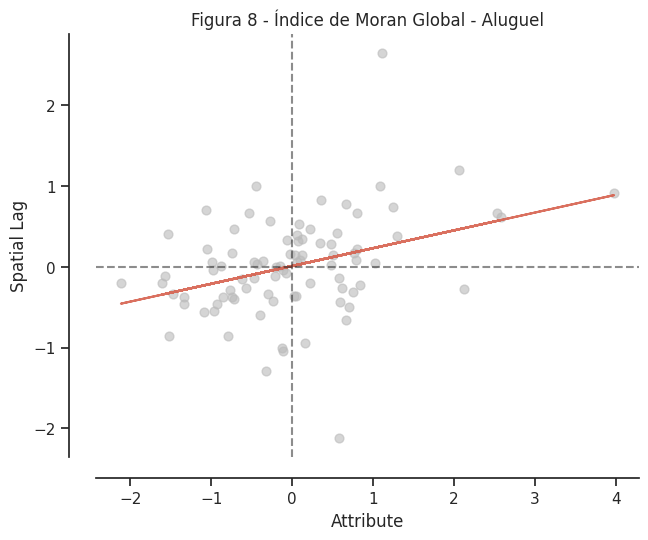

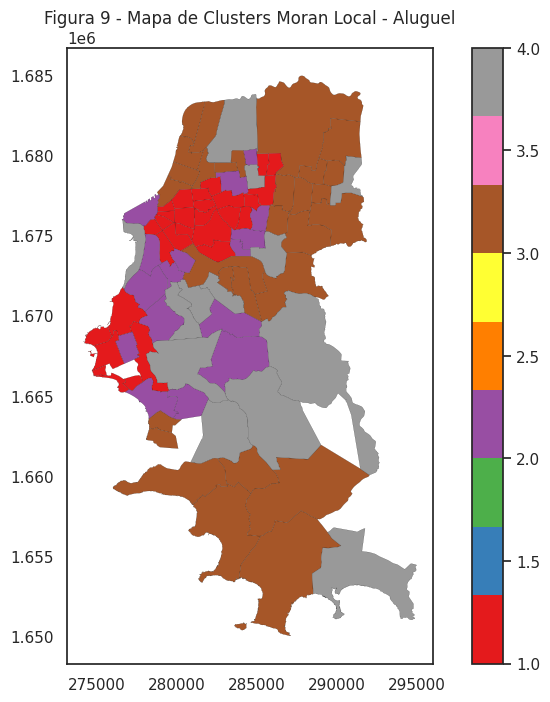

In [124]:
import geopandas as gpd
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
import matplotlib.pyplot as plt

# Calcular o preço médio por metro quadrado por bairro
preco_medio_bairro = dados_rental_filtrado.groupby('bairro')['preco_metro'].mean().reset_index()
preco_medio_bairro.rename(columns={'preco_metro': 'preco_metro_medio'}, inplace=True)

# Mesclar o preço médio com o shapefile e os dados dos bairros
dados_aluguel = bairros_shapefile_agrupado.merge(preco_medio_bairro, how="left", left_on="bairro", right_on="bairro")
dados_aluguel = dados_aluguel.merge(dados_bairros, how="left", left_on="bairro", right_on="Nome_do_bairro")

# Remover bairros sem dados de preço médio
dados_aluguel = dados_aluguel[dados_aluguel['preco_metro_medio'].notnull()]

# Criar a matriz de pesos espaciais (Queen Contiguity)
w = Queen.from_dataframe(dados_aluguel)

# Resolver desconexão se necessário
if not w.islands == []:
    print(f"Ilhas detectadas: {w.islands}")
    connected_ids = [idx for idx, label in enumerate(w.component_labels) if label == 0]
    dados = dados.iloc[connected_ids]
    w = w.subset(connected_ids)

# Padronizar os pesos
w.transform = "r"

# **Índice de Moran Global**
moran_global = Moran(dados_aluguel['preco_metro_medio'], w)

print("Índice de Moran Global:")
print(f"I: {moran_global.I}")
print(f"p-value: {moran_global.p_sim}")
print(f"z-score: {moran_global.z_sim}")

# Plotar o Moran Scatterplot
plt.figure(figsize=(8, 6))
moran_scatterplot(moran_global, aspect_equal=True)
plt.title("Figura 8 - Índice de Moran Global - Aluguel")
plt.show()

# **Índice de Moran Local (LISA)**
moran_local = Moran_Local(dados_aluguel['preco_metro_medio'], w)

# Adicionar os clusters LISA ao GeoDataFrame
dados_aluguel['LISA_Cluster'] = moran_local.q
dados_aluguel['LISA_p-value'] = moran_local.p_sim



# Criar o mapa de clusters LISA
fig, ax = plt.subplots(1, figsize=(10, 8))
dados_aluguel.assign(cl=moran_local.q).plot(column='cl', cmap='Set1', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
plt.title("Figura 9 - Mapa de Clusters Moran Local - Aluguel")
plt.show()


In [125]:
import geopandas as gpd
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt
from pysal.model import spreg
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm
import numpy as np


# Criar a matriz de pesos espaciais (Queen Contiguity)
w = Queen.from_dataframe(dados_aluguel)

# Resolver desconexão se necessário
if not w.islands == []:
    print(f"Ilhas detectadas: {w.islands}")
    connected_ids = [idx for idx, label in enumerate(w.component_labels) if label == 0]
    dados_venda = dados_aluguel.iloc[connected_ids]
    w = w.subset(connected_ids)

# Padronizar os pesos
w.transform = "r"

# Variável dependente e independentes
y = dados_aluguel['preco_metro_medio'].values  # Variável dependente
X = dados_aluguel[['densidade_demografica', 'qnt_domicilios_2022', 'qnt_populacao_2022',
                 'proporcao_rede_geral_esgoto', 'rendimento_nominal_mensal_percapita_atual',
                 'quantidade_alvaras']]

# Normalizar as variáveis independentes
scaler = StandardScaler()
X_normalizado = scaler.fit_transform(X)

# ------------------------------------
# MODELO COMPLETO
# ------------------------------------
print("\n======= Modelo Completo =======")
# Rodar o modelo SAR com todas as variáveis
modelo_sar_completo = spreg.ML_Lag(y, X_normalizado, w, name_y="preco_metro_medio",
                                   name_x=X.columns.tolist(), name_w="Queen")
print("\n** SAR Completo **")
print(modelo_sar_completo.summary)

# Rodar o modelo SEM com todas as variáveis
modelo_sem_completo = spreg.ML_Error(y, X_normalizado, w, name_y="preco_metro_medio",
                                     name_x=X.columns.tolist(), name_w="Queen")
print("\n** SEM Completo **")
print(modelo_sem_completo.summary)

# ------------------------------------
# SELEÇÃO DE VARIÁVEIS (p < 0,06)
# ------------------------------------
print("\n======= Seleção de Variáveis =======")
# Ajustar modelo OLS para calcular os p-valores
X_constante = sm.add_constant(X_normalizado)  # Adicionar constante ao modelo
modelo_ols = sm.OLS(y, X_constante).fit()

# Selecionar variáveis com p-valor < 0,06
variaveis_significativas = [X.columns[i] for i, pval in enumerate(modelo_ols.pvalues[1:]) if pval < 0.06]  # Ignorar constante
X_selecionado = X_normalizado[:, [X.columns.get_loc(var) for var in variaveis_significativas]]

print("Variáveis selecionadas para os modelos espaciais:", variaveis_significativas)

# Rodar o modelo SAR com variáveis selecionadas
modelo_sar_selecionado = spreg.ML_Lag(y, X_selecionado, w, name_y="preco_metro_medio",
                                      name_x=variaveis_significativas, name_w="Queen")
print("\n** SAR Selecionado **")
print(modelo_sar_selecionado.summary)

# Rodar o modelo SEM com variáveis selecionadas
modelo_sem_selecionado = spreg.ML_Error(y, X_selecionado, w, name_y="preco_metro_medio",
                                        name_x=variaveis_significativas, name_w="Queen")
print("\n** SEM Selecionado **")
print(modelo_sem_selecionado.summary)

<ipython-input-125-9160355fce22>:13: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(dados_aluguel)



======= Modelo Completo =======

** SAR Completo **
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :preco_metro_medio                Number of Observations:          87
Mean dependent var  :     35.3355                Number of Variables   :           8
S.D. dependent var  :     13.9394                Degrees of Freedom    :          79
Pseudo R-squared    :      0.4605
Spatial Pseudo R-squared:  0.4580
Log likelihood      :   -325.3500
Sigma-square ML     :    103.6167                Akaike info criterion :     666.700
S.E of regression   :     10.1792                Schwarz criterion     :     686.427

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----

/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


#### Métricas de Erro:

Erro Médio Absoluto:

Raiz do Erro Quadrático Médio:

In [127]:
# Variável dependente (real) e prevista
y_real = dados_aluguel['preco_metro_medio']  # Valores reais
y_pred = modelo_sar_selecionado.predy.flatten()  # Previsões do modelo espacial SAR

# Calcular o MAE
mae = mean_absolute_error(y_real, y_pred)

# Calcular o RMSE
mse = mean_squared_error(y_real, y_pred)  # Calcular o MSE
rmse = np.sqrt(mse)

# Exibir resultados
print(f"Erro Médio Absoluto (MAE): {mae}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse}")


Erro Médio Absoluto (MAE): 8.25258876208936
Raiz do Erro Quadrático Médio (RMSE): 10.600463040267758


### 8.3.2: Econometria Espacial para Dados de Venda:

#### Preparação dos dados para Venda:

In [128]:
# Calcular o preço médio por metro quadrado por bairro
preco_medio_bairro = dados_sale_filtrado.groupby('bairro')['preco_metro'].mean().reset_index()
preco_medio_bairro.rename(columns={'preco_metro': 'preco_metro_medio'}, inplace=True)

# Mesclar o preço médio com o shapefile e os dados dos bairros
dados = bairros_shapefile_agrupado.merge(preco_medio_bairro, how="left", left_on="bairro", right_on="bairro")
dados = dados.merge(dados_bairros, how="left", left_on="bairro", right_on="Nome_do_bairro")

# Remover bairros sem dados de preço médio
dados = dados[dados['preco_metro_medio'].notnull()]

# Verificar o tamanho do DataFrame após a remoção
print(f"Tamanho do DataFrame após remoção: {dados.shape}")

Tamanho do DataFrame após remoção: (90, 51)


<ipython-input-130-68512377c04f>:18: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(dados_venda)


Índice de Moran Global:
I: 0.49186175163278156
p-value: 0.001
z-score: 7.613317442031043


<Figure size 800x600 with 0 Axes>

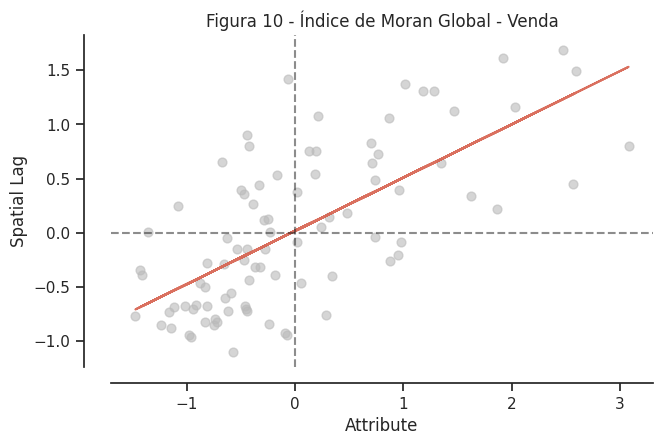

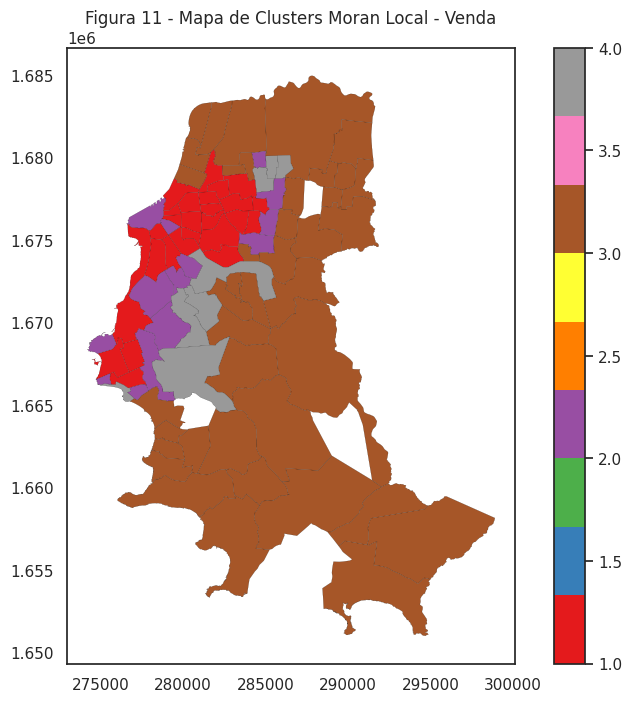

In [130]:
import geopandas as gpd
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot, lisa_cluster
import matplotlib.pyplot as plt

# Calcular o preço médio por metro quadrado por bairro
preco_medio_bairro = dados_sale_filtrado.groupby('bairro')['preco_metro'].mean().reset_index()
preco_medio_bairro.rename(columns={'preco_metro': 'preco_metro_medio'}, inplace=True)

# Mesclar o preço médio com o shapefile e os dados dos bairros
dados_venda = bairros_shapefile_agrupado.merge(preco_medio_bairro, how="left", left_on="bairro", right_on="bairro")
dados_venda = dados.merge(dados_bairros, how="left", left_on="bairro", right_on="Nome_do_bairro")

# Remover bairros sem dados de preço médio
dados_venda = dados[dados['preco_metro_medio'].notnull()]

# Criar a matriz de pesos espaciais (Queen Contiguity)
w = Queen.from_dataframe(dados_venda)

# Resolver desconexão se necessário
if not w.islands == []:
    print(f"Ilhas detectadas: {w.islands}")
    connected_ids = [idx for idx, label in enumerate(w.component_labels) if label == 0]
    dados = dados.iloc[connected_ids]
    w = w.subset(connected_ids)

# Padronizar os pesos
w.transform = "r"

# **Índice de Moran Global**
moran_global = Moran(dados['preco_metro_medio'], w)

print("Índice de Moran Global:")
print(f"I: {moran_global.I}")
print(f"p-value: {moran_global.p_sim}")
print(f"z-score: {moran_global.z_sim}")

# Plotar o Moran Scatterplot
plt.figure(figsize=(8, 6))
moran_scatterplot(moran_global, aspect_equal=True)
plt.title("Figura 10 - Índice de Moran Global - Venda")
plt.show()

# **Índice de Moran Local (LISA)**
moran_local = Moran_Local(dados['preco_metro_medio'], w)

# Adicionar os clusters LISA ao GeoDataFrame
dados['LISA_Cluster'] = moran_local.q
dados['LISA_p-value'] = moran_local.p_sim



# Criar o mapa de clusters LISA
fig, ax = plt.subplots(1, figsize=(10, 8))
dados.assign(cl=moran_local.q).plot(column='cl', cmap='Set1', linewidth=0.1, ax=ax, edgecolor='black', legend=True)
plt.title("Figura 11 - Mapa de Clusters Moran Local - Venda")
plt.show()

In [131]:
import geopandas as gpd
from esda.moran import Moran, Moran_Local
from splot.esda import moran_scatterplot
import matplotlib.pyplot as plt
from pysal.model import spreg
from libpysal.weights import Queen  # Corrigido para libpysal
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import numpy as np

# Criar a matriz de pesos espaciais (Queen Contiguity)
w = Queen.from_dataframe(dados_venda)

# Resolver desconexão se necessário
if not w.islands == []:
    print(f"Ilhas detectadas: {w.islands}")
    connected_ids = [idx for idx, label in enumerate(w.component_labels) if label == 0]
    dados_venda = dados_venda.iloc[connected_ids]
    w = w.subset(connected_ids)

# Padronizar os pesos
w.transform = "r"

# Variável dependente e independentes
y = dados_venda['preco_metro_medio'].values  # Variável dependente
X = dados_venda[['densidade_demografica', 'qnt_domicilios_2022', 'qnt_populacao_2022',
                 'proporcao_rede_geral_esgoto', 'rendimento_nominal_mensal_percapita_atual',
                 'quantidade_alvaras']]

# Normalizar as variáveis independentes (para o modelo completo)
scaler_completo = StandardScaler()
X_normalizado = scaler_completo.fit_transform(X)

# ------------------------------------
# MODELO COMPLETO
# ------------------------------------
print("\n======= Modelo Completo =======")
# Rodar o modelo SAR com todas as variáveis
modelo_sar_completo = spreg.ML_Lag(y, X_normalizado, w, name_y="preco_metro_medio",
                                   name_x=X.columns.tolist(), name_w="Queen")
print("\n** SAR Completo **")
print(modelo_sar_completo.summary)

# Rodar o modelo SEM com todas as variáveis
modelo_sem_completo = spreg.ML_Error(y, X_normalizado, w, name_y="preco_metro_medio",
                                     name_x=X.columns.tolist(), name_w="Queen")
print("\n** SEM Completo **")
print(modelo_sem_completo.summary)

# ------------------------------------
# SELEÇÃO DE VARIÁVEIS (p < 0,06)
# ------------------------------------
print("\n======= Seleção de Variáveis =======")
# Ajustar modelo OLS para calcular os p-valores
X_constante = sm.add_constant(X_normalizado)  # Adicionar constante ao modelo
modelo_ols = sm.OLS(y, X_constante).fit()

# Selecionar variáveis com p-valor < 0,06
variaveis_significativas = [X.columns[i] for i, pval in enumerate(modelo_ols.pvalues[1:]) if pval < 0.06]  # Ignorar constante

# Remover explicitamente 'densidade_demografica', se presente
if 'densidade_demografica' in variaveis_significativas:
    variaveis_significativas.remove('densidade_demografica')

print("Variáveis selecionadas para os modelos espaciais:", variaveis_significativas)

# Ajustar X para incluir apenas as variáveis selecionadas
X_selecionado = X[variaveis_significativas]

# Reajustar o StandardScaler apenas com as variáveis selecionadas
scaler_selecionado = StandardScaler()
X_normalizado_selecionado = scaler_selecionado.fit_transform(X_selecionado)

# ------------------------------------
# MODELO SAR FINAL
# ------------------------------------
print("\n======= Modelo SAR Final =======")
modelo_sar_selecionado = spreg.ML_Lag(y, X_normalizado_selecionado, w, name_y="preco_metro_medio",
                                      name_x=variaveis_significativas, name_w="Queen")
print("\n** SAR Selecionado **")
print(modelo_sar_selecionado.summary)

# ------------------------------------
# MODELO SEM FINAL
# ------------------------------------
print("\n======= Modelo SEM Final =======")
modelo_sem_selecionado = spreg.ML_Error(y, X_normalizado_selecionado, w, name_y="preco_metro_medio",
                                        name_x=variaveis_significativas, name_w="Queen")
print("\n** SEM Selecionado **")
print(modelo_sem_selecionado.summary)


<ipython-input-131-365b3771caa8>:12: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(dados_venda)



======= Modelo Completo =======

** SAR Completo **
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :preco_metro_medio                Number of Observations:          89
Mean dependent var  :   5456.5296                Number of Variables   :           8
S.D. dependent var  :   2410.5860                Degrees of Freedom    :          81
Pseudo R-squared    :      0.5319
Spatial Pseudo R-squared:  0.5084
Log likelihood      :   -786.2290
Sigma-square ML     :2691520.5519                Akaike info criterion :    1588.458
S.E of regression   :   1640.5854                Schwarz criterion     :    1608.367

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
-----

/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(



** SEM Completo **
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: ML SPATIAL ERROR (METHOD = full)
---------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :preco_metro_medio                Number of Observations:          89
Mean dependent var  :   5456.5296                Number of Variables   :           7
S.D. dependent var  :   2410.5860                Degrees of Freedom    :          82
Pseudo R-squared    :      0.4830
Log likelihood      :   -787.8145
Sigma-square ML     :2803462.8876                Akaike info criterion :    1589.629
S.E of regression   :   1674.3545                Schwarz criterion     :    1607.049

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z-Statistic     Probability
------------------------------------------------------------------------------------
            CON

/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(


#### Métricas de Erro:

Erro Médio Absoluto:

Raiz do Erro Quadrático Médio:

In [132]:
# Variável dependente (real) e prevista
y_real = dados_venda['preco_metro_medio']  # Valores reais
y_pred = modelo_sar_completo.predy.flatten()  # Previsões do modelo espacial SAR

# Calcular o MAE
mae = mean_absolute_error(y_real, y_pred)

mse = mean_squared_error(y_real, y_pred)  # Calcular o MSE
rmse = np.sqrt(mse)

# Exibir resultados
print(f"Erro Médio Absoluto (MAE): {mae}")
print(f"Raiz do Erro Quadrático Médio (RMSE): {rmse}")


Erro Médio Absoluto (MAE): 1150.4510612132665
Raiz do Erro Quadrático Médio (RMSE): 1640.5854296225639


In [133]:
print(dados_rental_filtrado.columns)
print(dados_sale_filtrado.columns)

print(dados_bairros.columns)

Index(['anuncio', 'id', 'tipo', 'preco', 'imovel', 'link', 'area',
       'preco_metro', 'cep', 'estado', 'cidade', 'cod_ibge', 'bairro', 'rua',
       'numero', 'latitude', 'longitude'],
      dtype='object')
Index(['anuncio', 'id', 'tipo', 'preco', 'imovel', 'link', 'area',
       'preco_metro', 'cep', 'estado', 'cidade', 'cod_ibge', 'bairro', 'rua',
       'numero', 'latitude', 'longitude'],
      dtype='object')
Index(['Nome_do_bairro', 'area_km2', 'densidade_demografica',
       'qnt_domicilios_2010', 'qnt_populacao_2010', 'qnt_domicilios_2022',
       'qnt_populacao_2022', 'percentual_pop', 'percentual_dom',
       'qnt_domicilios_particulares_2022', 'distribuicao_geral_agua',
       'proporcao_distribuicao_agua', 'agua_encanada_dentro_casa',
       'proporcao_agua_encanada', 'rede_geral_esgoto',
       'proporcao_rede_geral_esgoto', 'domicilios_coleta_lixo',
       'proporcao_coleta_lixo', 'rendimento_nominal_mensal_percapita',
       'rendimento_nominal_mensal_percapita_atual',

# 9: Mix - Regressão OLS e econometria espacial:

In [134]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from libpysal.weights import Queen
from pysal.model import spreg

# Função para preparar os dados com variáveis 'área' e 'tipo de imóvel'
def preparar_dados_ols(dados_imoveis, dados_bairros):
    # Merge das bases de imóveis com bairros
    dados = dados_imoveis.merge(dados_bairros,left_on='bairro', how='left', right_on='Nome_do_bairro')

    # Selecionar variáveis necessárias
    dados = dados[['preco_metro', 'area', 'imovel',
                   'densidade_demografica', 'rendimento_nominal_mensal_percapita_atual']]

    # Remover linhas com valores nulos
    dados = dados.dropna()

    # Criar dummies para 'tipo_imovel'
    dados = pd.get_dummies(dados, columns=['imovel'], drop_first=True)

    return dados

# Carregar os dados
dados_imoveis = dados_rental_filtrado.copy()
dados_bairros = dados_bairros.copy()

# Preparar os dados
dados = preparar_dados_ols(dados_imoveis, dados_bairros)

# Dividir em X e y
X = dados.drop(columns=['preco_metro'])
y = dados['preco_metro']

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar as variáveis independentes
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Adicionar constante ao conjunto de treino
X_train_scaled_with_const = sm.add_constant(X_train_scaled, prepend=False)

# Ajustar o modelo inicial com todas as variáveis
modelo_ols_all = sm.OLS(y_train, X_train_scaled_with_const).fit()

# Exibir resumo do modelo com todas as variáveis
print("Modelo OLS com Todas as Variáveis:")
print(modelo_ols_all.summary())

# Selecionar variáveis com p <= 0.06
variaveis_significativas = [var for var, pval in modelo_ols_all.pvalues.items() if pval <= 0.06 and var != 'const']
print("\nVariáveis Significativas (p <= 0.06):")
print(variaveis_significativas)

# Ajustar o modelo final com as variáveis significativas
X_train_significativas = sm.add_constant(X_train_scaled[variaveis_significativas])
X_test_significativas = sm.add_constant(X_test_scaled[variaveis_significativas])

modelo_ols_significativas = sm.OLS(y_train, X_train_significativas).fit()

# Exibir resumo do modelo com variáveis significativas
print("Modelo OLS com Variáveis Significativas:")
print(modelo_ols_significativas.summary())




Modelo OLS com Todas as Variáveis:
                            OLS Regression Results                            
Dep. Variable:            preco_metro   R-squared:                       0.146
Model:                            OLS   Adj. R-squared:                  0.145
Method:                 Least Squares   F-statistic:                     356.5
Date:                Sun, 05 Jan 2025   Prob (F-statistic):               0.00
Time:                        16:09:27   Log-Likelihood:                -74343.
No. Observations:               16727   AIC:                         1.487e+05
Df Residuals:                   16718   BIC:                         1.488e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

In [135]:
import geopandas as gpd
import pandas as pd
from libpysal.weights import Queen
from pysal.model import spreg
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

# **1. Preparar os Dados Geoespaciais**


# Calcular o preço médio por metro quadrado por bairro
preco_medio_bairro = dados_rental_filtrado.groupby('bairro')['preco_metro'].mean().reset_index()
preco_medio_bairro.rename(columns={'preco_metro': 'preco_metro_medio'}, inplace=True)

# Mesclar o preço médio com o shapefile
dados_geo = bairros_shapefile.merge(preco_medio_bairro, how="left", left_on="bairro", right_on="bairro")

# Remover bairros sem dados de preço médio
dados_geo = dados_geo[dados_geo['preco_metro_medio'].notnull()]

# Adicionar dados dos bairros
dados_geo = dados_geo.merge(dados_bairros, how="left", left_on="bairro", right_on="Nome_do_bairro")

print(dados_geo.columns)

# **2. Preparar Dados para Regressão Espacial**

# Filtrar colunas necessárias
dados_geo = dados_geo[['preco_metro_medio', 'densidade_demografica',
                       'rendimento_nominal_mensal_percapita_atual', 'geometry']]

# Remover valores nulos
dados_geo = dados_geo.dropna()


# Garantir que é um GeoDataFrame
dados_geo = gpd.GeoDataFrame(dados_geo, geometry='geometry')

# **3. Criar a Matriz de Pesos Espaciais**

# Matriz de pesos espaciais Queen Contiguity
w = Queen.from_dataframe(dados_geo)
w.transform = "r"

# **4. Normalizar Variáveis e Ajustar Modelos**

# Variáveis dependente e independentes
y = dados_geo['preco_metro_medio'].values  # Variável dependente
X = dados_geo.drop(columns=['preco_metro_medio', 'geometry']).values  # Independentes (variáveis dummies e contínuas)

# Normalizar variáveis independentes
scaler = StandardScaler()
X = scaler.fit_transform(X)

# **5. Rodar o Modelo SAR e SEM**

# Modelo SAR (Spatial Autoregressive)
modelo_sar = spreg.ML_Lag(y, X, w, name_y="preco_metro_medio", name_x=list(dados_geo.columns[1:-1]), name_w="Queen")
print("Modelo SAR - Econometria Espacial:")
print(modelo_sar.summary)

# Modelo SEM (Spatial Error Model)
modelo_sem = spreg.ML_Error(y, X, w, name_y="preco_metro_medio", name_x=list(dados_geo.columns[1:-1]), name_w="Queen")
print("\nModelo SEM - Econometria Espacial:")
print(modelo_sem.summary)



Index(['OBJECTID', 'CODIGO', 'bairro', 'EDITOR', 'DATA_EDICA', 'GEOM_AREA',
       'GEOM_LEN', 'geometry', 'contagem_aluguel', 'contagem_venda',
       'preco_m2_aluguel', 'preco_m2_venda', 'diferenca_preco',
       'GALPÃO/DEPÓSITO', 'IMÓVEL COMERCIAL', 'LOTES/TERRENOS',
       'PONTO COMERCIAL', 'PRÉDIO COMERCIAL', 'SALA COMERCIAL',
       'GALPÃO/DEPÓSITO_venda', 'IMÓVEL COMERCIAL_venda',
       'LOTES/TERRENOS_venda', 'PONTO COMERCIAL_venda',
       'PRÉDIO COMERCIAL_venda', 'SALA COMERCIAL_venda', 'preco_metro_medio',
       'Nome_do_bairro', 'area_km2', 'densidade_demografica',
       'qnt_domicilios_2010', 'qnt_populacao_2010', 'qnt_domicilios_2022',
       'qnt_populacao_2022', 'percentual_pop', 'percentual_dom',
       'qnt_domicilios_particulares_2022', 'distribuicao_geral_agua',
       'proporcao_distribuicao_agua', 'agua_encanada_dentro_casa',
       'proporcao_agua_encanada', 'rede_geral_esgoto',
       'proporcao_rede_geral_esgoto', 'domicilios_coleta_lixo',
       'propo

<ipython-input-135-877b6d9d6f7d>:43: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(dados_geo)


('WARNING: ', 76, ' is an island (no neighbors)')
Modelo SAR - Econometria Espacial:
REGRESSION RESULTS
------------------

SUMMARY OF OUTPUT: MAXIMUM LIKELIHOOD SPATIAL LAG (METHOD = FULL)
-----------------------------------------------------------------
Data set            :     unknown
Weights matrix      :       Queen
Dependent Variable  :preco_metro_medio                Number of Observations:          88
Mean dependent var  :     35.0021                Number of Variables   :           4
S.D. dependent var  :     14.2075                Degrees of Freedom    :          84
Pseudo R-squared    :      0.4291
Spatial Pseudo R-squared:  0.4318
Log likelihood      :   -333.2556
Sigma-square ML     :    113.9207                Akaike info criterion :     674.511
S.E of regression   :     10.6734                Schwarz criterion     :     684.421

------------------------------------------------------------------------------------
            Variable     Coefficient       Std.Error     z

/usr/local/lib/python3.10/dist-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 76.
  W.__init__(self, neighbors, ids=ids, **kw)
/usr/local/lib/python3.10/dist-packages/spreg/ml_error.py:183: RuntimeWarning: Method 'bounded' does not support relative tolerance in x; defaulting to absolute tolerance.
  res = minimize_scalar(
